In [1]:
import os;
import gensim
from idomaar import *
import progressbar
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
#reloaded_model = gensim.models.word2vec.Word2Vec.load("cheap_sessions.w2v")
model = gensim.models.KeyedVectors.load_word2vec_format("sessions_metadata_w2vf", binary=True)

2019-03-08 15:51:45,475 : INFO : loading projection weights from sessions_metadata_w2vf
2019-03-08 15:53:48,045 : INFO : loaded (5080028, 300) matrix from sessions_metadata_w2vf


In [7]:
# Not all values in range 0-numlines are used, but it's pretty close.
# Also, using a vector uses 58% of the memory that a dict would use.
track_artists = [0] * 5675143
track_names = [""] * 5675143
with open("../data/ThirtyMusic/entities/tracks.idomaar") as tracks_file:
    line = tracks_file.readline()
    i = 0
    while line:
        # we don't use album data because only ~38% of songs and ~48% of 
        # plays have album data.
        objtype, track_id, track_len, track_data, metadata = line.split("\t")
        metadata = json.loads(metadata)
        track_data = json.loads(track_data)
        artist_id = metadata["artists"][0]["id"]
        track_artists[int(track_id)] = artist_id
        track_names[int(track_id)] = track_data["name"].split("/")[-1]

        line = tracks_file.readline()
        i+=1
        if i%100000 == 0:
            print("{}%".format(i/5675143*100), end="\r")
print("100%")

100%7592763741813%%


In [27]:
# Load artist names.
artist_names = [""] * 595150 #This number is slightly higher than the amount of lines.
with open("../data/ThirtyMusic/entities/persons.idomaar") as artists_file:
    line = artists_file.readline()
    i = 0
    
    while line:
        objtype, artist_id, num, artist_data, md = line.split("\t")
        artist_data = json.loads(artist_data)
        artist_names[int(artist_id)] = artist_data["name"]

        line = artists_file.readline()
        i+=1
        if i%10000 == 0:
            print("{}%".format(i/595150*100), end="\r")
print("100%")

100%3467193144585%%


In [37]:
class ThirtyMusicEvaluationToolkit:
    def __init__(self, model):
        self.model = model
    def add_metadata(self, track_names, track_artists, artist_names):
        # Receives a vector of names and a vector
        # of artists for each track, and a vector of names for each artist.
        # Since the track and artist IDs are approximately
        # sequential, it's quite efficient space-wise to use a vector.
        self.track_names = track_names
        self.track_artists = track_artists
        self.artist_names = artist_names
    def get_artist_name(self, entity):
        return self.artist_names[int(entity.split("_")[1])]
    def get_track_name(self, entity):
        return self.track_names[int(entity.split("_")[1])]

In [38]:
toolkit = ThirtyMusicEvaluationToolkit(model)
toolkit.add_metadata(track_names, track_artists, artist_names)

In [112]:
most_common = model.wv.index2entity[:3]
most_common_artists = [entity for entity in most_common if "artist" in entity]
print([toolkit.get_artist_name(ent) for ent in most_common_artists])

most_common_artists_songs = []
artists = set(most_common_artists)
for j in range(len(track_artists)):
    if "artist_{}".format(track_artists[j]) in artists:
        most_common_artists_songs.append("track_{}".format(j))
print(most_common_artists_songs)
print([toolkit.get_track_name(ent) for ent in most_common_artists_songs])
# calculate the similarity of the songs, or plot the songs in some space or whatever
# maybe do tSNE?

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


['Lana+Del+Rey+(www.hitov.ru)', 'Arctic+Monkeys', 'Pink+Floud']
['track_232782', 'track_232783', 'track_232784', 'track_232785', 'track_232786', 'track_232787', 'track_232788', 'track_232789', 'track_232790', 'track_232791', 'track_232792', 'track_232793', 'track_232794', 'track_232795', 'track_232796', 'track_232797', 'track_232798', 'track_232799', 'track_232800', 'track_232801', 'track_232802', 'track_232803', 'track_232804', 'track_232805', 'track_232806', 'track_232807', 'track_232808', 'track_232809', 'track_232810', 'track_232812', 'track_232813', 'track_232814', 'track_232815', 'track_232816', 'track_232817', 'track_232818', 'track_232819', 'track_232820', 'track_232821', 'track_232822', 'track_232823', 'track_232824', 'track_232825', 'track_232826', 'track_232827', 'track_232828', 'track_232830', 'track_232831', 'track_232832', 'track_232833', 'track_232834', 'track_232835', 'track_232836', 'track_232837', 'track_232838', 'track_232839', 'track_232840', 'track_232841', 'track_

In [113]:
print(most_common_artists_songs[-1])
print(toolkit.get_track_name(most_common_artists_songs[-1]))
print(most_common_artists_songs[-2])
print(toolkit.get_track_name(most_common_artists_songs[-2]))

track_5021462
She+Loves+My+Automobile
track_5021244
She+Loves+My+Automobile


In [114]:
print([toolkit.get_track_name(ent) for ent in most_common_artists_songs[:10]])
len(most_common_artists_songs)


['Don%27t+Forget+Whose+Legs+You%27re+On', 'Joining+the+Dots', 'The+Afternoon%27s+Hat', '01.+Arctic+Monkeys+-+The+View+From+The+Afternoon', '01+Brianstorm', '01+Why%27d+You+Only+Call+Me+When+You%27re+High_', '039+You+Know+I%27m+No+Good', '04.+Arctic+Monkeys+-+Dancing+Shoes', '05.+You+Probably+Couldn%27t+See+For+The+Lights', '06.+Arctic+Monkeys+-+Still+Take+You+Home']


5544

In [115]:
# Do a tSNE run with the most important artists and songs.
vectors = []
for track in most_common_artists_songs:
    vectors.append(model[track])
#for artist in most_common_artists:
#    vectors.append(model[artist])

print(len(vectors))

5544


In [116]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vectors_red = pca.fit_transform(vectors)

In [117]:
tsne = TSNE(n_components=2, perplexity=80)
vectors_tsne = tsne.fit_transform(vectors_red)

<IPython.core.display.Javascript object>


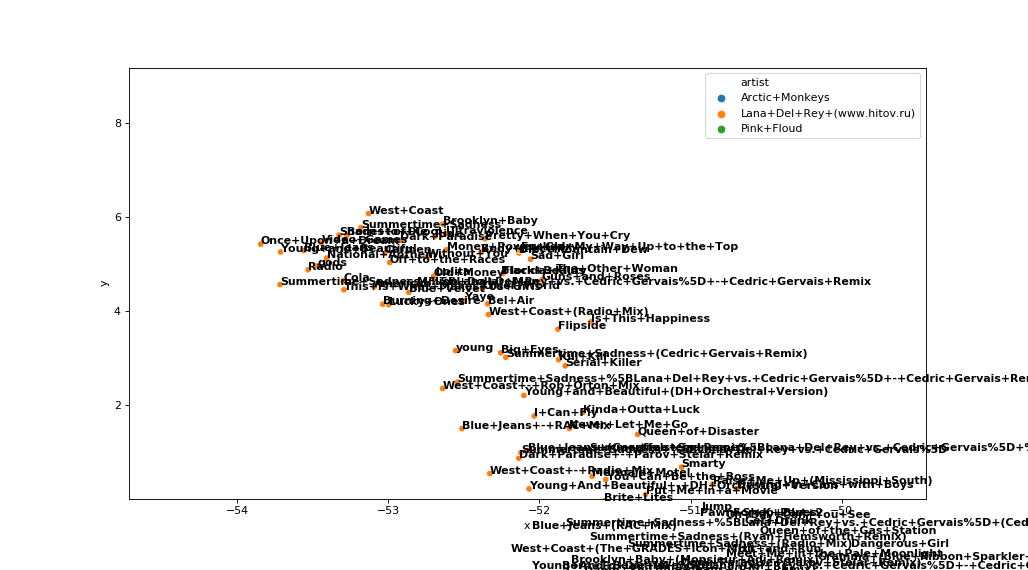

In [159]:
import seaborn as sns
from matplotlib import pyplot
import pandas as pd
%matplotlib notebook
#fig = pyplot.figure(figsize=(7,6))
tracks_subset_artist = [track_artists[int(j.split("_")[1])] for j in most_common_artists_songs]
tracks_subset_names = []
vectors_df = pd.DataFrame(vectors_tsne)
vectors_df.columns = ["x", "y"]
vectors_df["artist"] = [artist_names[track_artists[int(j.split("_")[1])]] for j in most_common_artists_songs]
vectors_df["song_name"] = [toolkit.get_track_name(j) for j in most_common_artists_songs]
#pyplot.scatter(x = vectors_tsne[:, 0], y = vectors_tsne[:, 1], c = tracks_subset_artist, 
#               label = tracks_subset_artist, alpha = 0.5, s = 3)
#fig.legend()

p1 = sns.scatterplot(data=vectors_df, x="x", y="y", hue="artist")
for row in vectors_df.iterrows():
    p1.text(row[1]["x"], row[1]["y"], row[1]["song_name"],
            horizontalalignment='left', size='medium', color='black', weight='semibold')
#vectors_df.plot(kind="scatter", x="x", y="y", c="artist")

In [128]:
[artist_names[track_artists[int(j.split("_")[1])]] for j in most_common_artists_songs]

['Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Monkeys',
 'Arctic+Mon

In [123]:
tracks_subset_artist[0]

29427

In [121]:
fig.legend()

2019-01-10 22:55:52,460 : WARNING : No handles with labels found to put in legend.


In [ ]:
most_common

In [73]:
vectors_red[:,0]

array([-0.43451392, -0.36867487, -0.22565017, ..., 18.4879598 ,
       18.68521264, 18.00646275])

In [107]:
model.most_similar("track_5021462", restrict_vocab=10)

2019-01-10 21:09:47,527 : INFO : precomputing L2-norms of word weight vectors


MemoryError: 

In [4]:
#reloaded_model.wv.most_similar("artist_235220")
#word = reloaded_model.wv.vocab.values[0:10]data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXYAAAD8CAYAAABjAo9vAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4xLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvDW2N/gAAIABJREFUeJzs3Xd4FVX+x/H3ub2lN9IgDRJ6Cx0ERIqgiIgFFUFQ7Gvf1V23/CxrWV11bbu62BUpKqKCYEXpNfQSenq9ye19fn/cGEEsILlA2PN6Hh4nk8mck5j7ycz3nDlXKIqCJEmSdPZQne4OSJIkSS1LBrskSdJZRga7JEnSWUYGuyRJ0llGBrskSdJZRga7JEnSWUYGuyRJ0llGBrskSdJZRga7JEnSWUZzOhpNTExUsrKyTkfTkiRJrdaGDRtqFUVJ+rXjTkuwZ2VlsX79+tPRtCRJUqslhDh0PMfJUowkSdJZRga7JEnSWea4g10IkSmE+FoIsUMIsV0IcXvT/r8JIcqEEEVN/8ZGrruSJEnSrzmRGnsAuFtRlI1CiChggxDi86bPPa0oypMn0xG/309paSkej+dkThNRBoOBjIwMtFrt6e6KJEnSzzruYFcUpQKoaNq2CyF2Aukt1ZHS0lKioqLIyspCCNFSp20xiqJQV1dHaWkp2dnZp7s7kiRJP+s31diFEFlAT2BN065bhRBbhBCvCiHifss5PR4PCQkJZ2SoAwghSEhIOKPvKCRJOkO56sHdcOx2hJxwsAshLMD7wB2KotiAl4BcoAfhK/qnfubrZgoh1gsh1tfU1PzcuU+0O6fUmd4/SZLOQO4GWPpn2DwH3FZY+gDs+hS8jog1eULz2IUQWsKh/o6iKB8AKIpSdcTnXwE++amvVRTlZeBlgMLCQvl+fJIk/Y8QUHgtKEH4+u/QfTLE54DeErEWT2RWjABmATsVRfnnEftTjzjsYmBby3Xv1Pvss8/Iz88nLy+Pxx577HR3R5Kk1k6lhvdnwKJ7Ia0HvHspbHgtolfsJ1KKGQRMAc790dTGJ4QQW4UQW4DhwJ2R6OipEAwGueWWW1i8eDE7duxg9uzZ7Nix43R3S5Kk1iwUgktfh/oDsOBmaDcQulwa0SZPZFbMcuCnisyLWq47x2/BpjL+sWQ35Q1u0mKN3Ds6nwk9T26Sztq1a8nLyyMnJweAK664go8++ohOnTq1RJclSfqfpIDfA4GmiReOmnAZ5kwoxZxJFmwq4/4PtlLW4EYByhrc3P/BVhZsKjup85aVlZGZmdn8cUZGBmVlJ3dOSZL+x6nUsOBGKLgQbtsIjirY8PqZM3h6pvjHkt24/cGj9rn9Qf6xZPdJX7VLkiS1KJ0Zpi0GjQ5MCXD9N+FtecV+tPIG9wntP17p6emUlJQ0f1xaWkp6uvxDIUnSSfDYYO/nYCsDn+OH7aA/Yk22ymBPizWe0P7j1adPH4qLizlw4AA+n4/33nuP8ePHn9Q5JUn6H6cEoXgpvHY+fHoPfPw7KC8C/8ldiP6SVhns947Ox6hVH7XPqFVz7+j8kzqvRqPh+eefZ/To0XTs2JHLLruMzp07n9Q5JUn6H2eKhwkvgTEOtrwH3a6ALhPBEB2xJltljf37OnpLz4oBGDt2LGPHygUqJUlqIe5G2DYfGkshJgN2fQwDbobkTqCOzIKCrTLYIRzucqBUkqQznhKEfV/BuH9C10thwU3hUkxctgx2SZKkVskUD+OfA6EOl1+O3I4QGeySJEmRZor/6e0IkcEuSZIUYTa3j0a3H39QwaBVk2DWof/RBJCWJINdkiQpgqxOL0Uljdz3wRaqbF66Z8Tw7OSeZCWYI9Zmq5zuKEmS1Fq4/SFueXcjVTYvAJtLG/nzgm1U2SL3pj0y2I8wffp0kpOT6dKly+nuiiRJZwmb24/Ld/QSKOsO1hMMRe5tKWSwH2HatGl89tlnp7sbkiSdRaKNWvSao6O2R2bsMftaUusM9oAP3poY/ud1/LAd8J3Uac855xzi4yM/Yi1J0v+OOJOW56/sSbQxPKSZm2TmsYndSLDoI9Zm6xw8nX0FHFoZ3v5nxx8W05l9BUz54PT1S5Ik6UeMOg1DOySx5I5z8AVCmHRqkqIMEW2zdQb79wLu8D8AzcktACZJkhQpOo2a1JhTl1GtsxRz2ZvHPoqr1sLlb52e/kiSJJ1BWmewz73m2LWMg36YM+X09EeSJOkM0jqD/XsaI+ijW6wMM3nyZAYMGMDu3bvJyMhg1qxZLXJeSZKkU6l11tgnvxceKIVwWWbuNT/sPwmzZ88+yY5JkiQdq87hZW+1g+JqB4PbJ5Jo0WPRRy5+W2ewa3RHz36RM2EkSTpDWZ0+nv5iD9mJZtolmFmwqYw+WXEMzE1ECBGRNlt3KUaSJOkM5/YHuKhHOku2V3Hne0XsrLARbdBidZ3ccze/5IwKdkWJ3CO2LeFM758kSWeeYAgqKyvJjlHj8AUY3k7P2uJyfIFQxNo8Y0oxBoOBuro6EhISInZ7cjIURaGurg6DIbIPFkiSdHaJVTkZ7lzE4G69mVzYlbxDc/Gn9kalyoxYm8cd7EKITOBNIAVQgJcVRXlWCBEPzAGygIPAZYqiWE+0IxkZGZSWllJTU3OiX3rKGAwGMjIyTnc3JElqRXQqUBwVWBZOIy6jEErWYB/9LEIJRKxNcbzlBSFEKpCqKMpGIUQUsAGYAEwD6hVFeUwIcR8QpyjKH37pXIWFhcr69etPrueSJEmtQEWjmxRVIyrrQfjwRpTL3yZoSsShjiPWfGLrxQghNiiKUvhrxx33FbuiKBVARdO2XQixE0gHLgKGNR32BvAN8IvBLkmS9L8iWe1AfPQ78Lvg2k8R86ejtrTBMvYpIDILgf2mwVMhRBbQE1gDpDSFPkAl4VLNT33NTCHEeiHE+jO53CJJktSSFNQw6iHI7Av/7ARZQ2DEXxCayK3ueMLBLoSwAO8DdyiKYjvyc0q4rvOTtR1FUV5WFKVQUZTCpKSk39RZSZKk1sarCCgvgti2cPUHEJUG5ZsIhSI3K+aEgl0IoSUc6u8oivL9U0FVTfX37+vw1S3bRUmSpNbLoHihdg98cgesewU+vRNqd6P6fmXaCDjuYBfhOYizgJ2KovzziE8tBKY2bU8FPmq57kmSJLVu9UoUof63QJdJsHsxdL2UUN+bsIqYiLV5IvPYBwFTgK1CiKKmfX8EHgPmCiFmAIeAy1q2i5IkSa2XURVA5aqFvjMhKhU6jUe4ajAYUoHIrNF+IrNilgM/9+TQiJbpjiRJ0tnFJPyIpX+Cqu0oE/6NmHctqsQOmC5+OWJtnlFLCkiSJJ1thFoD5z8OWgPizQtBpUEZ9xSo1BFrUwa7JElSBDkVAwoq8LnCO/zh/9owRaxNGeySJEkRZAi5EIvvBUMMzPwGzImIT+/GHHJGrM0zZhEwSZKks5FarYJzH0BRFBRDDKrxz6No9KgiuNahDHZJkqQIsgZ1xBkTUFQa9rsN5Jq1KCoNtQHDTz+m3wJkKUaSJCmCTCEXys6FeA+sRBPw4Nu2EOXwaqJU3oi1Ka/YJUmSIkgIAQEPxg+vJSuzL5SuIzhx1k+vvdJCZLBLkiRFkFqlQtXtcnBWw+qXYOSDiLTeCOV/4B2UJEmSzkohP0rlFkT20PDKjkEfwlaCJqlzxJqUNXZJkqQIUqMgtn8E86bCweXw/nWw6xM0yv/Im1lLkiSddTQ6GPEAJBXA6hfD67L3v5mQkE+eSpIktUreICg1e6BqO5gSoGwD2MvxiMgsAAYy2CVJkiJKTwCxbT50nww3rYD8cbBjIaaQK2JtysFTSZKkSNLooPsVKEEfiseOqucU0BpQRfCt8WSwS5IkRVBIF40qNgtFrWG73USXBAOotWCM3BttyFKMJElSJHltiEV3E/zsz2RpbYgFN6Ksfgmf0xqxJmWwS5IkRZDVp8Y64D60xYuIerEr2Mqo6TSV+qAcPJUkSWqV/Ioanz4e9FEABCzpWH1qgsHIPXkqg12SJCmCkvU+UhZdB4YYbONfRVO7i/Y7XyBRF7kHlOTgqSRJUgSpdSaUy94giIq319u54YZlqFQa9ObYiLUpg12SJCmSfA7EontRa03ceMEziHnXIGLawsi/gTEuIk3KYJckSYokrQmG3I14fRxi50LQGGDUI6CLjliTssYuSZIUSRo9xOdAXBYEfZBcANGpoJZrxUiSJLVObit8dAvYymHkg1CxBT7/W3h/hBx3KUYI8SpwAVCtKEqXpn1/A64HapoO+6OiKItaupOSJEmtVlMphnP/DAm50G5QeF8ESzEnUmN/HXgeePNH+59WFOXJFuuRJEnS2USjhzbdQKhArTli+wwoxSiK8i1QH7GeSJIkna00unCo/3g7Qlqixn6rEGKLEOJVIURk5u5IkiRJx+1kg/0lIBfoAVQAT/3cgUKImUKI9UKI9TU1NT93mCRJknSSTirYFUWpUhQlqChKCHgF6PsLx76sKEqhoiiFSUlJJ9OsJEmS9AtOKtiFEKlHfHgxsO3kuiNJkiSdrBOZ7jgbGAYkCiFKgb8Cw4QQPQAFOAjcEIE+SpIkSSfguINdUZTJP7F7Vgv2RZIkSWoB8slTSZKkSHPVg7vh2O0IkcEuSZIUSa56mD8dit4Bjw3mXwtb54W3I0QGuyRJUiSpNND1UljyR3iuJ5RvgqwhoDVHrsmInVmSJEkCQzR0vACi08BZCx3GQkz6mbGkgCRJkvQbuOph7lTwOaHwOtgyGza/F9FSjHyjDUmSpEhSaaDHZBjzGMRkQNu+0KZ7REsxMtglSZIiyRAN+eNAYwyXX47cjhAZ7JIkSZGmt/z0doTIGrskSdJZRga7JEnSWUYGuyRJ0llGBrskSVKkuerB7z52O0JksEuSJEWSqx6+/juUrAVP4w/bvsiFu5wVI0mSdCq8PRFSu0PlFuh0EYjINSWDXZIkKZJM8TDiL+B3hRcCG/sUtOkGWmPEmpTBLkmSFEmueqjaBh0vhNzhYIiFqq3hcDdER6RJWWOXJEmKpGAAtsyDeVOhZg/MnQIb3oCgL2JNyit2SZKkSIpKhpF/g9pd8O0T4Tr7+Y+HSzQRIq/YJUmSIingA+shqNwK+iio2QW1xRDwRKxJGeySJEmR5HPAxreg/Ri4exd0mgjrZ4HPFbEmZSlGkiQpkkzxMOIBUBTQWWDMI+HtCJZiZLBLkiRFminhp7cjRJZiJEmSzjIy2CVJks4yMtglSZLOMscd7EKIV4UQ1UKIbUfsixdCfC6EKG76b1xkuilJkiQdrxO5Yn8dGPOjffcBXyqK0h74suljSZIk6TQ67mBXFOVboP5Huy8C3mjafgOY0EL9kiRJkn6jk62xpyiKUtG0XQmk/NyBQoiZQoj1Qoj1NTU1J9msJEmS9HNabPBUURQFUH7h8y8rilKoKEphUlJSSzUrSZIk/cjJBnuVECIVoOm/1SffJUmSJOlknGywLwSmNm1PBT46yfNJkiRJJ+lEpjvOBlYB+UKIUiHEDOAxYKQQohg4r+ljSZIk6TQ67rViFEWZ/DOfGtFCfZEkSZJagHzyVJIk6Swjg11qnUIh8LuP3ZakM5GjGuyVx25HiAx2qfUJhaB+P6FDq6ipb8BTXUzw0Cp8bsfp7pkkHcvdAIvugbcnQmMZvHcVfDAzvD9CZLBLrY/PTmjLHFTvTiJq40sY3hwDy54g6Pee7p5J0rGMsTDyIXDVwdOdoK4YLnga9NERa1IGu9T6GGLw9bmJYO4oDMsfA62Z2nGvMv29PdQ5ZLhLZyCtCYxN75hkiAW9BVSRi18Z7NIJq3N4WbG3lrdXH+JQnROnN3BK2/f6/KhdtahrtodfMPZydLXb6Z9pIvSzzz5Lv8btC1Jt81Bj9xCSP8iW426ARXeDowomz4GgF96/PqKlGPnWeCfIHwxidfoJKQoGrZpYk+50d+mUqnd6uWNOEd8V1wKgEvDOdf0YkJt4yvoQ8trR7F2KctV8gvo4/GtfJTalLTdlxiJM2lPWj7NJvdPHi1/vZfbaw8SZdfz1ws4MyE3AopcRcdK+L8WEAhCXDdd+Ft6OYCmmVf1fq3V4cfuCaNUqYoxajDr1Lx5f5/ByoNbJ4XoXQ/ISEQIMOjUW/W978bt8Ab4rruX+D7ZS7/QxIDeBZy/vQXK04TedrzWqd/qbQx0gpMAji3byxrV9SbDoT0kfHJiI7XEl6tdGE8wfj67/jYjXx6AtvA7R+xpQm09JP1q7GruHTYcbMOvU7K528N/lBwBw+tzMfGs939wzTAZ7S4lrF34DayGO3o6QVlOKqWhwM2XWGoY88TVD//E1728sxe7x/+zx9U4v98zbzIw31pNo0fPl7mpmvrWRu+ZsZl+1A38wdMJ9aHT7ufmdjdQ7fQCs2lfHP5buxnWKSxGnk8cfPGaf3RMgpJy6W/d4s56D9T5sA+9Dv/Ip1M90hKAfpeOFoJOhfjxq7B4m/XsVM9/awKaSRhZvDS/SqlOryIw3oteo2HDIepp7eZY5MsgjGOrQSq7YHd4Ajy7eSaPLzxOTutE+2UJxlR2nN0CUQXvMsY0uHw0uPxq1irk3DGBzaQP3vb+1+Zjle2v56u5htIk5sSvtknoXwR/VHlftq8PhCwebwxsEAVF6DeZWcqVjdfoIKQpRBg11Dh/L9tQQY9RSmBVHUtSxP5+UaD0ZcUZKrT/MG58+KJv4U1iSUqsEacmJGGIGgz4GPA0oWUNQGaJOWR9auzUH6jlU5wKg1OqiQ0oUXdJjuLBbGvtqHGQnmok3/2+VGc8mrSJ93L4gnkCId6/vzx8/3Mrq/XV0SoumW0YsyVEGVKrwXz9/METRoTq+3FHBBT3bcs/IPPZWWpm7rvSo87l8QYpKrIyJST2hfqTHmRAifBf1vV5tYxEI/r5oJ3PWl6IWgmsHZXHD0Nwz9oVh9/ipd/rYX+PkX18WY9ar+fMFnbj4xZW4fOEr8uxEM3NvGEBS1NHllaQoA/NvHMis5QcorrZzWWEmA3ITUKtP7c2fKeREvHlBuH456HeIrx6CNl2g1zWt6qrd4Q3g8PgJKWDSnboxG6vzh7vdjzeX89Etg9hw2Mol/17Z/Pv91ws7kRpj/NWSp3TmaRXBbtFruH9MAffO38y6g+Hbw21lNq59fR0Lbx3UfGVpd/noYrIyoA+44wyIhhKyEpyU5sex/ke3lT8OrOMRY9Dyj0nd+ctH23D5gnRJj+YvF3Zm1b463l1bAkAQhf98u59zOiQxKO/UDSj+GkVRqHV4sXsClDW40alVTH9jHYoC0wZm8eI3+5pD3aLX0CbGwN5qxzE/J7snPHB8Zb9MzDoNcSYtWs2pfeHX2j0EvQGSRj5MMKkTXm0MpuQuqNp0blWhbnX5eOXb/bzy3X78QYVzC5J5YlI3Ek/BWMWIjsk8skiFxx/C6Qtidft5bPGuoy5aHlu8i7FdUmWwt0KtItiNOjUqlWgOdYteTYxRR5XNg9MbJCkKGt0+9CEHxvXPo9r+PsZRj6D++mGUlC5MmfAqzy07jKOpFt43K452CSceABaDhgu6pTKkfSL+YAijVk2MScuXO39Yhj4txoBJr+HbPTVnVLCXWt1MfHElt56bx8E6J0atuvlFbNSqKW362VzZty0X90pn5d5arE4ftQ5vc9A4PAE+3FTGe2sPs6PCTkqUnjem96UgNXKj+z9mc/tpdPvZcMhJv7Z9+MdnB/lkyxZuPSeDi2JjyLGETvndw/fqHT78oRBqlTiucD5c5+LFb/Y1f/zVrmo+2FjKjME5qFWRrcEmWnQs/t05PPdVMSM7JZMSbaDBffSYlTcQIhA68bEo6fRrFcEO4AuEuKh7KneN7IBarUIlBMFQCIM2fDVRZvWwvLiRKcP/irF2F+pP74T4HMrPe4GHPz7EWzP6srvKTnKUgc5p0b/pqsjq9BFCQasSpESbmvcPL0hixb5aHr+kGx5/kEa3n4G5CQSDpy9kjuT0Bnjis13UOLxo1YJ6p4/CduGHJSx6DT3bxnJOh0SqbF5GdEzmlnc2MrwgmcP1LhZtK+eRi7sSY9Th9PkZ2Ebh4iva8dC39cwsjCVV04DNpSPadGpmBvmDIYIh8IcU7v5gV/Od2PPflvLexmoW/W7IaZmldLjOxa2zN7KltJG8ZAsvXNmL9smW5jLhT/mpwcmVe+u4sl+7iM9G0WnUZCeZeeCCjjS4/Hy+vZJhHZL5evcPFyndMmKaX19nE68/iBACneb0vzYjpdUEe3KUnofG5lDpCaFRYH9ZNc+vqGB4fhJTB2axfG8Ny4urmdFJgfr9IFRgr8TgqiAYCDLxpZXkJFrwB4PMv3HgCbdfZnVTbfewpbSRjqnRpPqCZMQZEUIwpH0ir1xTyF8+2saW0kYAog0aPr5t8G+6M2hpHn+Q/bVOLHoN3TJi0GvUpMUa6ZIezU1D83h37WGG5yfx7BU9WLi5nOcm92RTSQMDcxIwaFVU2bzUO3wk6Pwk2tahDibw+HntUXYvQhXKRzHogDan5HsJKgreQIi8JAvrD1kZ1SmFK/pm4g8qvL7yYHM5KRJ8gRBuf5AoveaowK62ebjpnQ1sL7cBsLfawdRX17LwtkEk/8QA9Pf65cQfs294QTKmUxCmgWAIq9tHg9PHtnI7L3yzj1euKSQrwYhOo6ZzWjQDchNO2RTW79ncfsoa3Hy2rZKC1Cj6ZMW3WGnK5Q1Q4/Di9AYQQhBl0JAcpUd3ikuJp0KrCfYoTwXs/5q09uPx2Ovp7/qGhh792VLro9Tqpn1yFB1igoiVz6LE5xKYPBf1wluIXfEw9577Iia9jgWbKxnbtQ0WXfgvdYPLR5XNy8ZDVrq3jSUtxvCTg1dWp5cvd1Xxl4+2M7JTCrEmLRa9hmqbB7VaRbxJx3aPrTnUAS4tzMTtC7K/xoHFoCHRrP/Fq7dIijVqmdAzHbcvyH+W7adzegzxZh2PTOiK2x+kXYKZ5GgDGpWKoe2TcPmD5KdYWHuwjoG5iQRDIeq9AfQJJqLyx8CL/RHmJETPq+HdS2H4A9B3JuhMv96Zk6RRCdSq8NTT16/tg9sX5J+f70GjUnH7ee0xRageXGXz8J9l+9hZYefC7qmM6dKGeLMeq9NHndPXHOrfq7R58PpDWJ0+rC4fNk+AtFgDSRY9ommqW3qskT+O7cjzXxUTCCmM7tyGC7qnnpLfk+JqB08t3U3/7AQ6pkVT7/Rx/wdbeH5yL+ZvLGX+hlJ8wRAjClKIO0WTAEIhheV7a7n5nY0AFLSJ4slLu7Nyby2BkMKgvEQSzDpsHj82dwCVShBj0BBznAPOVpePZ74oZkFRGQDnd2nDny8IDxCfbVpHsPtcUL4R1Se3YyrcjKV4KeijGH7pBSQlqrjw+eU8fVkPtpT46D3kTxg1gn02NabBj5Fg0aGze3moWx2j2ndgZIcYtGUr8Kf2Yv6GOh7+dGdzM/eM6sD0QdmYfnQb7PKHeGrpHu4/vwC9Vk1RSQNxJh1/+3g7GiH4/fn5uHxBhIABOQnMPCebXRUOLnhuOYGQQnKUnvdm9icnyXKqf3IAqNUqLumVQY3dwzNf7OHjLRVkJ5q5pFc6yVEGxnZpw62zNzL7uv54/EHKaqxkJMfhDypEaYK4QhreWVPO6M7J6BMg/op3Ea+PhUX3oHSeSLDH1WhOQahDeDZHvFlHnElHWYObaa+ta/7c9NfXRaQUU2P3cuUrq9lX4wzvENAnK56tpY1o1SrqnT6yEkwcbJo+CBBr0qJVCx5YsI1Pm+aIJ1p0fHjzIDLjTU3H6JjYK52RnZJx+4LEm3UkmCN/hVzr8HLb7E2cV5BEz3ax7KlyML57GuO6pXLr7I3sqXKQm2ThrVWHKLO6uXFYLvpTcFVb5/Ty5JLdQHhK66MTu3LdG+uptHkAaJdg4t3r+/H1rhr+vWwf/mCIaQOzmNQrgyRD8IeBc5/zmEH0QCjEhkNWPtxU1rxv0dZKhnVI4rI+bSP+vZ1qraPIpDMRyjuP0KC7UK1/FVz1BK75FJ82htdWHMSsU5MWa2DG4Bw82liWlSo4vQH2OvUsO+QjvXEjUfMuZYz/c7QLrod501AT4rUVB49q5rmv9mL/iYeNBBBj1JCbbOHRRTsZ3z2NGW+so292PDcNz8Vha2BkW8EXt/XlnmHpDEmDGquVOLOOq/u1ZWSnFB7/bBcNLt9J/RisLh/VNs9vWugq3qwj1qjD2HSbf6DWyXNf7aV3u1iW7alBIDDp1RQmeBirK6J9rGBKZx3p1d+gCzpZsr2SwlQ9seXfIhpLIBB+sYm6vahD/p98WCwQDFFjD689EvgND4T9FJNeza3vbqLO4WXO+pKjPqco8OHGsp/5yp8XDIaotnkos7qosR/7s3V4A82hnmDWcc+ofCa+uJI3Vh3imz01vLbiAE9e2p2kppJBtFHDa1MLqbZ7+XRrBakxBm4elssNQ3P5ZEt58wNt1XYPD368nQc/3smHm8p5bPEuSq2uY9o/EbV2L2UNbuocXqxOL3UOL8qPHh4LhhSu7NuW8T3SKbO62VNpp192PDmJZmzuAG/P6MfNw3K5sHsaQ/OTsbt//kHAluZr+j3plx3Pqn11zaEOcEG3VMqtHh5YsI1Sq5sqm5cXvt6HMWCFFc+Csyb87/vtI6gQbDx87Nosaw7Un5Xr4rSOYAc0HiuqbXPDK6P5XVD0Dh5HPXqtmkW/G4JAcMM7GzhQ4+STLZVsr2ikY5tokmPN2NOHEBp8N6ol98OBZTBjKQ1BPeWNR785gzcQOuYBJACLTsO0gVl8s7uGjqnRrD9kpbBdPNkJZv69bB/dzfWonu5Em/p15Fi/Q/10J+4ZGMtr0wpx+4N4/EGuH5KDL/Dbw63M6uaGtzbQ9+9fMmXWWvZU2U/4FzLWpOXuUflEGzXMGJzNwxO6oFYJ+ufE88b0PljUAdSHvsPy8XXEbnwBy3sTUH35IElmLaM6p7CtOoDoMBoW/4FQj2sI3bYRHJWENs9B8R0dSA0uH7PXHmbcv5Yz7l/LeW9dyUn/YYNwnXv9ISubSxtpG3fsXUK7hBO7c/AHQxSVNnDBc8sZ9PjXXP6fVeyvOXpdd90RA+AXdk/jrVWHsHsDROnVDMtHgtlAAAAgAElEQVRPYnK/tmw8bOXJy7oxZ2Z/3ri2L5nxJnZV2BmQm8C/JvdkX42DT7dUYNCqm2dnVTZ4mNy3Hb3axXKg1kFBajRWlx+379efZA4EQ1TaPCwsKufLnVXUObwcrnNy5X9X8+wXxWwpbeTGtzcy7bV1fLq1gsYjwtmoVZMeZ8CgVXPX3M0kRukYmJuAXqPiiUndeGTRDt5Zc4jle2u5/o31WF2nJtjjTDpuHJob7qNOfdR4iUYlGJafxDd7qo/6mow4I3jtsObfMG8azJ8Bq18CT+NRx6lUghEFyce0OapTm9NWIo2k1lOKKdsA+iiC1y8jtHsJ2jXPk9H9Ku4Z2QGAGW+uo7BtPBnxJqYObIcQsLPSTpRBjUEVRJRvCJ9LUQiVbcSUl8KYzm1YvO2HdzIZnp/0kzXaaJOWib0y+GRLBZkWaJ9kwazT0GizUW3zsqEhjiGFMzDPD78tbHDoH3Gro5n43Ep8gXD4fry5gqV3nfObvv16Z/jWeePh8CyKHRU2rpn164NzP6bXqpnUO51RnVNYd6Cetgkm6p0+cpOisLl9zCuq5dKuozH0vQXdiqdAayJ02yY2lIfw+ENsKmsk0ZJC9vQv2Gf189CHFTw/5Ut21nh599N9PDS+M0adBr1WzZ4qO3/+aHtz2w8s2EZ+m/Bg2MnQNC11uqnEyn2j8lAHXTzxVSkjC+KZ0CWRnrnhsoZRp8bu8eP2hZ8Gjjfp0PzEDCWr08eMN9bT0BRe+2ud3PruJt6a8cPaNzqNiot7pvPhpjKiDBoO1Dppl2Diyn7taHD7SbLouWfeluZzatWCBTcPon2KhXtH5zN11trmO8GikgYMWjWXF2YSQuHV5fv5vGm67Bc7q7m4Zzr3nV+AUffLL83KRg9jn/sOmztAnEnLq1P78PCinZRZ3fz94q5c/vJqkix6huYnsXR7FQkmHQOapt9qVIJAUKHG4WXqgHaM6JjSdEeioFap+L/xXdhe3kiN3cutw/NYua+W9Dgjpl/p08nSqFWM6ZRCv+x4QiEFvVbNy9/uJzlaz7+u6IleI8hJtISfPK8O//ENhhRW1poZedV8xKyR4RNd+xnEZh1z/vw2UdwyPJf/fncARYEpA9pRmBUX0e/pdGkdwa4z4cgchnHaMEqcWoIp55Ix5XzWVgTJS1bjDwSYOSSXib3SOFRjo9LuJ79NFOXVNVzeIwn14RWI8k0oN63Ct2sJ+s/uQ3/7GB6a0Jk+WXG0iTGSm2TBrFc3D2z9WKwmyGWdTAT2rECXPAhXign1vuWMu7QvXx7woaR0/eHgNl1ZX+psDnUI32LOWXuYP5zf8YS/fX9QaQ7171XaPOHQOgEefxC7N8h/v9vPiIIUdGoVCrD2QD25yWYqGz0YFRfafZ+BRg9+F8Hdn9G7w3hW7NMzICeBN9cc5LohOVw4axm+gMJ1H4a4uEcqd4zowIvL9lPe4ObuUR1YsKn8mPYXFpUdV7B7/EEaXD72VjtIjzMSZ9I1D2qb9WrGdU3lvPwEzI17uCGjnEvvHUi85zAB604+2O6nqCrAnee155FPd7JoWyXxJh0PTejMkPZJxyz14PYHuWNwCoesPl5bV83fRmVwuMHPkfdCNXYPQ9onMrZrKnaPn+6ZsRyqc/Lsl8VoVIK+2cd+T/5giA83lnFOftIx5b131hxiTOcUEsz65lBv/hltLucPY/LxBoI0uPx4/eE/UglHDL77AyFe/m4/NncAi17DK9cUolYLNh62MiAngRV7a7myb1vGdGnDgk1lJFp0xJp1uH0BjDoNWrWK3CQLTy3dzd2j8ml0+blrbhE3D8tlZOc23PT2BpKi9CRHGbhr7mYendj1lKwFVOfwUmn38teF27jv/AKStWreua4fapXg9+9v4fLCDMbkxzD2mhzeLaonxmxgQkcLQqWGhY+DtmkQdNnjcMkrWInGEwihUamIN2nZdNjKhd3TuLwwEyEEFQ3un7xDPxu0imB3eALsbYDMBCMLt5RwUY9U1lS42F7eSP82Cuq6TYzt0I1YxUZysIhdsZ0ptbqZkCvQPp2Pb/pXaG5ahWrBTYgL/oWz6xV4/Xre31TKwNwknvp8N9/srkEImNQ7g/vP73j0cgA+N5SuRZfUAd3qp2H5o0QVXIhY/QKqK+ZzSXYimldvwzvwHhRPA4Z5VzP0xnV0TY9ha9kPt4QWw29bVVIlBNmJZg7UOpv3Rek1JzzHuMbuxeENMLh9EmqV4N/f7qNLWgxtE8z4AiEm90qCA59DKETo9q2w7QO0K5/BlTuOywoz0WtVXH9ODgKBSgjGdElhSv92xBi1XPHyamqaav93jexAx7Rj123p0fbnr44CwRAObwCzTsO2skaufGVNc731hnNyuHl4HjFGLbEmHQ9e1Bm114Zq8+eov3uU+MLrURe9TSh7BJ0KH2JDhY1XvjvAx1vCg5Z1Ti83vbOR734//JhgT9J6uES7gkD7bMZ360pB9SJ0XXJp8LvYV+Mnwaxj/oZSXl1xkJRoPW2iDUzomc7Ijim8tuIg3kCI6YOzjzqnP6ig06g4bHVh0Ki4sm9bLuqZhkoIDte7WL2/Fo1ahRDB8NXzEeGiVQsEsGx3DXfOKcLpC5IWY+CtGf3ITQ4PvgebniIGmNgrnfkbSumcFkPPzFgCoRAFqdHoNSqunrWm+SG0DzaVseSOc8LBrlERZdCQGmvku+JwLfrN6X1Zsr2SeqePRy7uyvqD9ZTUu/nLhZ2otnkIKTHH+2t2XOocXlxNK7VGGcJrK/kCIfyuRuZMKcCOheLSClKjtDQoZkw6NeO7p5EQrEbzfE+mjf0nAUMimvceI3TJq4iaXYRmfIlKpYJ3JhF0NfB/X5ayoKiczHgj787oT1qsibUH6umYGo2iQFmDm8QoPccWaFq/VhHsbn8AXzCEyxtiZEEiGcEy4uPN9MnMQHPwC8Scq0kd+lcMJd8iyjdScOtGOqh0lNYGMA29D92sYRCdjqPTFXy7z80Tyw7w2rV9WL63jpAC3+wO/3IrCsxbX8r47mkMaZ/0QwcCHji8ChbehjLtE8SLAxCrXyDU/xbsiT3RiSDaqz4klNyVQDCEttM4PJpoSq0/PFUYZ9Jycc/03/T9J1p0PDe5J1NmrcHq8mPSqXl2ck9ijcf/h6LR5cPtD2DUqslPsXDPvM3cdm573P4gRq0GRVEwWSzY2p5H9IzRlLj1JHW8jFD+JZS6dby5+gBqIRjfow0dkqO547z29M9O4N75W7hrVAdqHF7SY43cNiIPfzBEXlIUfbPjWXugHggPhg1p/9NP4tY5vMzbUMrnO6q4d3QH/vrRjuZQB3j5u/1MHZhFTNP3m2DRgyUJb78bCFVuRL3uZUjIo27EU1zx/CZ+PyafBZvKeGBcR3q3i8MXDGH3BDhY6yTjR3V5g1qgOEpRf/0AcbkjoHgpnvOfpTiQh9oUE766bQrUKpuXq/u1Y1h+MtV2D+d1TOH1lQfZV+Pg96Pz8QSCDMxJxKBVkR5r4MlLu+PwBMhNMjP11bV4/CG6psfw0tW9iDJosbn9XN2/Ha+vPNjcn+uH5BBU4HfvbcLjD/8Myhs93Dm3iNev7UO8WY9WreK6wTks2lpJt4wYnv2ymDqHl2cu70mD20e0QcOjP1oeoMHlZ/W+Oi5q+h2MM+kYkpfI9gobozu34bbZm8iMMzKpdya3zt7Izgo7AO+uPczjl3RF0HJXtpWNHma8sY7t5TZ0ahV3j+rA5L5tMeOhm2sVqvlvYbzkTbo0LsOwai5Jl7zOoxd35atd1Zzf3oTmnL9g+eR21ICr9w3stmrJm7GSao+CWash6aY1/H3pfhYUlSMEjOuailYtAIXlxbX85aPtaFSCKQPa0audLMWcNiohyIwzUuv00SlejXrWVURpjIRGPohwVKMMuRvjsv8DwHNLEZrGUnSzL6Pt9M8RMRnhk9jKIDYLtUbLmC5tqGj0kJVgPmb+MUB5gxu7x49Bo0arUYEpDvrfDLFZiG3vg88BOjOqXR8T1/dGPj4giDYWoKtUCIWgS9oA/r54N6vvLGTBLidGnYoxuSbcqt82ZUwIQUGbKJbceQ4ub/jWPNakPe4paG5fgFX76uiUHo3T48ek0zJ1YBZJUXpq7F4WbavgluF57K1yYNRp8DYEqWisp3NaLBNfWodOo2JM5zYYtCoeXbSbV67pzbW9EzlQ6+Dinul0ihc8OyGH9DYpbC1rYH+Nkz8t2MYD4zryhzEFaNXhWPjx7AwAh9fP45/tYu760qaPg1T8aFBbUSCkKNTYvaiEQpRBi8vtIcp2ENWBb8GcCPX7MJSu4Lp+WRysc3Hv6Hze31jWPJ01O9HMWzP6HtO+yhyPcu79sP9LKF6KUnABtpxxFO910sUiWLa7hnM6JNI9I4ZHJnRhX62TF74uJsaoY1TnFIIhhVnfHuC16X14b10JX+yspCA1hoCikJ8ShVsleOiIKbVbyxp55otiHhzfGW8gRKe0aP4zpTdbyxrpmRlLeYMbly/QHOoQrokLwrOzqm0e5qwrIS3WyPybBpAea+Tr3dXMGJyDw+vn6llrmDYw66gB32H5SUzqnUHntGisTh/+YIhoo5a+2fFkJ1lQFIW91Q7OLUjC7Q82h/r3XvnuACM6pvBLa2fWOrzUOrwIBIkW3c8+2OT2BXn2yz3NrztfMMSji3cxoWcaOrUekdod8dkfMLw8AOyVBEY+gsMbwmzQsKfKQY8kKEjJaz6fMTmPw/Venl6+i0m9M/j7op28OrUvs1aGZ0z9YXQBndKjcPkDrDtoZemOqvByGii8tuIgozu3OSMeImxpLTIrRghxUAixVQhRJIRY3xLnPFIgpPDM58UkmvXsqAvhu3wuNJagmjcVJbU7lG1sPlZVuRl1VApKwYVo3LWIhbegDPwdoaH3YVnyO4a28dKrbSztEszsqbLTPyeh+WvVKsHzk3ti1muYt76UxdsqqLJ5wqWY8iJI6w5F78KIv6LcugG0RoL7v6N/WxNRBh0Pf7qDaa+vo94V4L6BZvRzL+eirABj0n3o5lyGyVOB3fPbZoZo1CqSowxkJZpJiTac0LxiuzdAYpQejRDEmnTUOb0UtotDo1Yx860NDO+QRCik8OryA7i8AaKNWrpnxmPUqYkz6Whw+XlvXQnL99byxKRuuBwNqIsXk1u9lGmFCaRVfc049WqKS8p4d00JBanROL0Blu6ooqTehQA+3FDGoq2VFFfZKWtw8/xXxTz31R5s7sBRc4tX7q1lXLejV918dGIX9lQ5qLF5cHmDlDV48LkdhPYsJZgznNBtRQQH34t5zwdc2z+NkR2TsRg0fLipDCGge0YMKdF6/vvd/mPXk3c3IIrehZpdkNIFsWcxcfWbGJpj4ZpZa/nzR9uY/PJqnrqsO2q1it/P30LXjFiG5Scx/fV1KIrC05f3YN2BesZ3T6PBHeCFr/fy3toSXN4gB+uc/NjGQ1acviBmvYbnvirmwY93UHS4gT99uI0Ve+sw6zVEG8PXXOcWJDP/xgFM6p1Bg9vP5FfW8NTne7h73mYsWjV2T4D7z+9ItF7DxsMN2NwB5q0v5ar+7dCpVdw4NIfzu6Ty0aYy6p0+7pxTxCX/XsmXO6tw+IIYNCoMWjVCQG6S5aiy0Pd+ac7I97Nxrv7vGsY88x2jn/mWaa+to/ZH00brnT4O17mosXvYeOjYaYd1di/OgILfnEaoyySwV4IpAdFrCofdOgRwbn48BbFBxNwpKP1uJDT8AcTie7kww8HDF3XF7vbz3vUD0KoFndOiyYg10jcnngSTHpNOw54qO3Nv6M+CWwax8NbBzJ7Zjx3ljcf05WzQklfswxVFqf31w05cIKTw2Y4q7hzVgQqrnU5JHgj6oPPFCOsBKN9I8KbViAPL0CW3h6J3UTL7hMP4ynmQkIdfbUaVNRS3PomkKC17q+zccV57vIEQ1wxox5x1JUzokYZGJYg16/hqVzUalYrMeBMxsSF0lZvDtdPpn6FU7YQ9S1CmLearHTVkBzTsrrJS6/DRPSMGl89Psl4PXjuGN0aFLzktyVQ5QqzYW8mEXumn5IGP7wnCdyHeQJDcJAvf7qnh4l4ZbCtt4PLe6ZybrafB7SLepGVghhaHL8SmKhf/+XY/71zXj399WcyBWidPXtadKf9dw59GpJEZsqP57F60uxbC/q8Jnvcg7eKMPDGpG/5gkCV3nMOColLap1hYvLWCc/KT+GZ3NecWJHP+s99icwf452XdOVzvItqgpc7pw6hVMygvkaxEM9EGLV/srObP4zqSYAnPaKlsdBNrjqa0zsnji4t54LxJFPSYyg1vb+exsdOI66Vh2tvFGHVqLu6ZTk6imScmdWN7uQ2HN8CwDuEr0qPGJpQQWA8RuuBf2PMuIGr1U2ArZ687u3nQs7zRg1olqHP4UAlBxzbR7KiwcfuI9vz3uwPkpVhIiTLw6KKd6LVqLi/MICPOSKXNTVaCGZXgqPdiHZSXiMWgwahV886M/vzt421sL7cxLD+Ze0Z1INak463p/Xj40x3cMDSHya+sAeCVa3qzr2kqprrp9/Sb3TXYPH5GdUohPdZIglnHVf3bkRlnZOGtA/EFFcY/v4K3Z/Tj9/O3cHmfTB6a0Jlle2oZ+sTXBEIKf7uwE1P6t8PrDxFv0tI5LfqoO9nbR7QnwazD4fHjDYSIMWrRqFVYnT7eXHUQjVrFrsofrvK3ljXyzZ5qJvXOBMJX87fP3sSKfXVcVpjJwNwEdlf9cHy7BBNJUQaE34l275eo1r2C0v1KxJ7FqN67kryLXsMuDGTEWwiqQXPVPITbGr5bn/IRAUsGSkBhcPskpsxai0Gr4unLeqBWCYpKGuiUGo1awK3D89hU0sAjTXdQ1w3JYUyXE1u6u7VoFaUYg0bF9EFZBEIK57WPQfXfi1Ey+6EMuA3VoeUoN63Er7bgzZ+ERa9BlTsc8epoaD8KEnIRH8xEM/NbZh1O5tHPwkvVXtwznd+P7oBGHV4X4+ZhuSiKQqnVw+RXVjdfuSzcXMYXdw0lrfNEhN/PHpuW3Pg81Mn5uEOC/LZtyLb4CaRo+PTaDsSZtfzf16X8dWQ6ykUvIF45F4DGS97jT1/UsOGQleEFySRHn1iwh0LhATOnNzyz4fsBp+OhUQkMWjV5yRYc3iCj8mNJ1Xl4rriWJ8amoXq+N+YRj/DYiL6on++NZtxLdEwbxKp9dUx8aSU3Ds3hij6ZLNleSa3DR6ecTA64LyAv+2PY/zVk9iXQcypKRYArXl7NPaPy2V1pY0eFnexEC90zY7lzThHzbxzAJ1sqsLkDjOuWSpf0GJ5auoe7RnbgTwu2cfuI9nxUVMaS7VWM757GA+M6IgRsLm2gX3YCmfFmvP4AIQWKShtRGTvT75k1ePwhrKECRjwVnl5q0Kr4/ZgCHp/UjTvnFlFSHy7tPP/VXhbdPoS4Ix5B92hj0Ay+G08A+j21lnV33kEQFW8u2N98zLWDstA2lTZykswcrHPyfx9v58JuaTxzRQ/ykiw0uP1MGZCFVg3tk6OZu6GEV5YfYHKfTJ6+vAd/W7idRrefy/pkcvt57ZsfFGubYOLpy3vi9QeJMmiapzl2y4jhhSt78ZePtuH2B9FrVEctd5Fg1mIWPnKTzSzfU0ucNoDdrOP1a/uw7qCV11YcZHeVnUF5iahVommOenfizFoaXH7eXHWQBy/qQm6Smf01DoZ2SCI32cznO6p44cpeLN9bQ2Wjl0mF6Zi1GnZX2nn6iz2UN3i4e1QH8lOi8AVDlDd4fvKSftcR5ZxV++pYsa+OpCg99Q4vk8/No6LRzdIdVaTGGHhzel+mvraW16b2xpfUBe35T+LrfCnagbejOrQclUpFg9NLjEnHNwc9DFJ7MX4wE5QQobv3Uh0wY3V7Wbq9isP1LuJMWvyhEFf/dx3/uaaQkKIQCEGV3cNtszc19+u22Zv44OaBpMWefUsKtNQDSgqwVAixQQgxs4XO2SzBoufaQVm0UVkRzhqUq96HCS8iNHqUvJF40dEQ1OPTWPjmoAeiUmHo76HnVSidLkYZfAfVHhVPLi2mfbKFc9on0jU9Bl8wHN4JZj1xJh0ateD9jaXNod4vO57rhuRgCjlQLfkjurcvJDNwGE3Ig/hXT4y7F5AeKEH1rx50iQuR+s1d6OZO5uERSRjshxFzpkBie0jII+ajqTwxMo7kKP1vGoY6UOtk3HPLGf7UMgY//hUfbizF4QlfUfoDIWrsXmw/84Sg3ROgIDWKbWU2YjRBCvw70S64ngdHp4PbitLnegwNxWjeuohgQgf8Kd3whgT3jSnA6Q3w90W7+GZPDTV2LxN6pGFS3CSVfQkHvoX03lCyFs2OD3E21pObZGF05xQWFJWjVQvaJ1uYvbaEK/pk8vmOKlDgjWv7cP/5BdjcfpZsr6TE6mLejQMY07UNH2+pwBsIMW9DKTUOL++sOUzbBDOKouD2BQgq4RxJsuipaAwv29wu3ki1zYsvoDAgJ4E/ju0IKJRZXc2hnpds4boh2eyutOHzB/EHgxyud1FcZafCZ6RRMdIu3kyPJ9dT6dEybVAWEF63/7yOKTg8AQ7Xu/jDmHwK2kQhCE9NrHf4uHNuEXEmLfHm8LjHnio7/bLieeSiLgzMSyQ12sAntw3muz+cy7n5yZRZ3Uc9PRxj1JIcbWgO9Rpb+L1IKxo9NLj9ZMQZuX5INha9hr7Z8SRadCyaUYBl03/oHBvk5r7RRG16mTY6F/9Zto8h7RNZtqemeb69XqMiI85IKKSE/x8Af7+4K3PWHebyl1czZ30psSYt0QYtF/VM54klu9hWbmNs1zbY3AFKGtxc+d81LNlexQ3n5HCw1snOChvBkMLag/WM7JhyzO/c5L4/PKa/pbSBP47tyJOTupGfGk2N3ctdI/NZdf8IFt46mHfWHObC7mk4/QolIg17h4lUejSsscXhKpiIQ5gwG7ToVSGGGA9gfP9qAj2vgZQuqF8eQpKw4fIGmt/Va2SnFOatL8Xq9vNdcQ1uf5BAMMSCTcc+lfzhxtJj9p0NWuqKfbCiKGVCiGTgcyHELkVRvj3ygKbAnwnQtu2Jr80QrfKhKCHEB9eH14HoewN8fBtKj6sQA++i0eFHr1ExKFOH+PBaaD+KkLsR1ad3o4z7J1Z3kLev60d5o4temXHc98FWZi0/wOWFGYztlopWreLjonLMeg1qleCZy3tQ7/RRUu+kqFph6Oj/5+69g6M4sLX9p9Pk0YxylhAiR5EzGDDB2BiDbcA2zgHHdd51Wq/XeddpnRPG2DjhCBhjY0w0OSeJJIRyTpNDT3d/f7Quu3v3Vv3Cd7/gPVUqqaTS1LQ0c7r7nPd93ueQProQx5JxMOsFjMmPIqy5FxugFk0lkLCSdMGLyEunwZLzYMFnkD+Kjol/JhRLkLf7KVRDZkLPNJz/H4we4VgCX0TloW+PnLO7J3SDx1eXMrVfJrGExrIdlXx/uJ7CNCdPXtyf/GTHP7np4prO8p1VLBpTSFQDw5mJWLcfx0fTwZWNMe8dKF0Jl30AohV3+WqMoln4InGW3zgKgFA0QZbXxokGP5JgIMYDaOc/SWzwNRiHP8ceCyA5De6d1pPq9jBum8xDF/QlzWXFYZHok53Esu1neffqYSR0g7VHGxjdPZU+WW7e2VLBz6WNLLv+78tNt1VmcJ6HZdsrEYFkp4Umf4yfjjYyZ0guXodyLgRkYq900t1W7p/ei8wkG9vLW+md4T63gLxpfDem9ctC0w28DoW6zgiKLJqjBU3n0e+OcvWYQp6bN5C//HSCqvYIbaEYf1tQQoMvytqjDURVjatGFaLpBjZZ4s0rh/JzaRNDC5O558tDtAfjxBMGSpc3INVpIabpTHt5K1P6ZHDbecUsfG/XOTflhJ5p/G1Byb8sGZv8UR759igbTjTz8AV9eGB6byKqxp6Kdo7V+bhzcg96ZjjxBE4i/Poi1obDiL5aBH8dKSVXsmh0IQbQJ9tNKKbRLzuJb24dQ1zTyfRYOb47wKwBWVy7dC8VrSGsskjfbDctAVPVlOWx8/y8QQRjCe778hCLRheSmWSjPRRnfI800lwW3HaZ/GQHFS0hkmwKlW1hnpozgANV7dxzfk8sisTus+34oiqWLk7RppPNPL66lAsHZlNa7+d4g5/rx5kyUUkAt01hyktb2PGHyTRGE3gcEuvKWuiX3RPZgGg8hoREcmZfYhe8THvhBaTZDIyTPxE3JD7dXc384fm0BGLcNqn4nNKowRfF61DwOhS6pf3rkvT/FL/pf3X9t1yxG4ZR1/W5GfgO+Bf5gWEY7xmGMdwwjOHp6en/+cf/zyWYt67GxW9A62lYcRWGpwBjzF34DTtq1xk5qCkkpjyB1vsifMUXk5j/GUZGf9zeNO778hDdUpw89+MJ0lxWXrh8ECeaAmw80cznu6t5Z2sFlw/P4/KhuVS0BMlIsjKuRzpFaU5TOiZ0/bmqd0G38eeeWjRvHJvLO0C2g81jLn7WP45+wV9R7RmsrxEoG/YkO5tl7p/ei4iqsa60kRV7q2nwRVC1/9po1BGK89bmckrr/Zxq+mebu26Y9vr3tlbw+sZyKtvC9MpwU9cR4ekfyli+s5KWgMnZsCsyJfle3FYZr9aK4ExBH3WrCUua8yaCGoZdb8Gae5H2vI207iGcvtPUtgeZ/+5O9pyuJctjY1dFG2MKHOxr1GjqNoeG7pdzz3dnCPe+jPCAK2lN2OmW6uTzPTU8O3cgcU1D03VuGl9Esz/KHVN6kNAM9pxtJ9VpwTDgnUXDuHtqT/62oAQwiXsWSeSrW8dwojHA4kndue+rw2iagSTAjjNtJDSDpdeNIKHpXDWqgFkDs4moGkPyvaw90sC8Ibn8eU0ZfbLd9Eh3MqckF39U7dKQt/PE96WcaQ7ijyZ4a+MZHphhNs+7VxzkwoHZFGe4eOS7YyzdfvQHmfcAACAASURBVJZcr43MJBvfHKhj1eF67BaRYEylJN/LgzN7Ud0e5s0rh2K1iPxc1khhioOemW5CcY2Xfj7FQxf04abxRbyy/vQ/WeR/Pd1Kg+/vHJRYQqPRF6HJH2XDiWZmD85h5oAsLLLItUv30BGJU5TuZG9VO0fr/GxoT0Wd8y7SiTUIDYdIXPcjLaTQPcNFaZ2PWyZ0556pPfnT6lLaugJTMGDBiDxiCZ2KVlOt9dlNo7DKEk+tOc59Xx6mvDmI0yoTS+g0+WPkeW147Ao2ReTJOf3xOkzmUH1nhEdXHuWpS/ozJN/L+X3TeXBmH2RJZMmvFQwv8LLnbDsXvb7NfMu0hXnmkoFEVY0R3ZKZNzQXHQOnRWLWwGw+2HaW6f0yCcU13HYZQzeY1jcTUQRJhJ5JCRQtxMl2HcvAuZS3RGiJyRh959Cp2+mdlYQiizw9dwCLPtjNnCG53D6pmP45SVz69k5e+vkkFwzIpjj97829ON3JzAH/e3DT/7vrf7qxC4LgFATB/R9fA9OBY/+zj/svpaugqwgxP3jyYcEnCBgIhkESEdLdVvJTHIQSIu+etNMkpBGIwxmxGwFb1rmQZqsicbTOx7Vju3Ht0j2omsFFg3KwW0yGx5+/L2PxpGJU3SAS1zCA1tYW5J8fBjVC8LrNMPVxhA8vwBh+I/oVX+H+9Unm9HUhf38HxIPEFnwJbacRVt1Be1szjb4Idncyo4pSaA+pLHh3J4uX7+cP3xxl6ktbqOuI/peHXN4c5I1NZzhQ3cHE/6QBd3XdWfwHgnRwnofB+R6uXLKbpdsr+eOqUha+t4vWQIzWYJRj9X5cRhBn+RrEml2IO16D4qlQuQWjtRzjxvXQVAqHv8CY8RyB9KH8WNrC/ZNyWJxTSSYteGSVpLpfmZqtEhWd/FwRo0+Wm7jsoiluw2mVkSWR7eUtFKY6SHNaUTWDJb9WMLN/Fn2z3BjAutImxhan0eiPcv7LW2j0RRBFgar2MJcPy2fJtcMwgIe+OUppnZ+vbx3Dsp2VSJLI4xf3Y/muSp7/8TgWSeDWScUUpDjw2mVWHarn9sk9uOOzg5Q1+Hlh3UmW3ziKtccaMAwoTHXytw2nmNk/ix4ZLjTdYEiBl6XbKumTlcTsQTkMzveQbBPIcFvQDYN9FS1M6Z3OpF7pfLSjkovf2M4j3x3DpkiEYhoVzQHagjE+2HaWXpluwqqGrht0hOKku6y4bTKHa33nDEVgmpCuGVOIyyp1AdI0atojrD5UT1vQ/L3bzyumvDnI8l1V6AZM7ZPJttOtLByRz5rD9YzOFpF3vgoWF0gK4tYXSRLCYOh8truadLeVTccb6ZHu4lBtJ3ZFQhIFXFaZjrDKpJ5prLlzPKuPNLBsRyV1nRH8UZWEplPeHEDVdOo6w+R47MRUjUdm9cUXjpPQdH4tbybZYaEjpOJUJBwWCVkSKav3U9UW5uKSXBI6vL7hNADxhMalw/J44ScToJfitKBqBmsPN3CqJXhu53HXlB7sqmhHEQV0zPFZXDdIIoj0ySWkBY7TTzuB8MYwxmVEyWzagvWdEWQpIUYXpdAjw8WKPTU0B2LIgsCCkfn8dd0J/nLpIK4ZW8SPRxtYdv1IViwezZeLx/DxDSP/lwea/J+q/46jygS+67Liy8BnhmH89N/wuP9UMc3AIllM2M+sF6BmD8xfDpF2LKJEhsXJeb3ScRt+5ve1EjVMxkq624ZhmFe/A3M9VLWFuHRoHuvLGhmS7+XRWX258v1d/G3hEJZur6Ss3k91e5hJPdNJdipc/s5OnFaZDTc/g6ElUB3ZqGob8sLPwZMHVTsw7tyHCBjTn8aQbURtOWhXryUU03hjWwsuq8KB6k6WbDONNhX/4CANxzVe33iaZ+YO/Ce1hqYb/Fpuioy+2FvDl4vHkNANNhxvpijNyQuXDzJhTl47Tf4YFw3O+Rda5ZmWEIGYiqoZ7DzTyiUlOfQddAVyezlctwYcqRiGDpIV9r4PggCyDeHgcsSiC9l071hSLQmUNc+Rct7DzC2yI6x6FT33Xfq6IzQm25lTknNuROSwSMRVjbV3TzT18laZQDRBSzCOIArEEho2RSQzyYoOfLqrioRuUNcZZXt5KyOKUpn31g4+uXEk8YRObrKdiwZns+F4M+9sqcCuSFw0OIdJBTKjC7L48HA7fbw647q5CQhOuqc7iaraOcjW9vI2jjf4yU6yEdd0Sut9fLV4DG9uKmd8z3QUyQxJ+bm0kWhc48JB2RQ7olgb97DtjkHIiTDEOok7wnw4J43TkW40hgT65bhJdlqobAsxrkcad31xiMwkG3dO7smpJj+ZSXaafFEuH57H21vOoIgic7oUV5cNy2NcjzQ+31PNrNe28cmNI6lsNfjmQB0RVWNir3TmDc1h5cE6zu+bgcsqs2hUAQgG9b4oIjCs0IM73oIQaiV20xakcAvyxiexG2GskUaenduXNL2NG3rHKFWzcNqsnG4OMqJbMghwrLaTP88ZQJM/ytoud26/7CRemV/CJ7uruKQkl9WH6rl/Wm8C0QSSKDAw14NFEvHYFUryknFYZR67sC9WRaLOF8LjUHDbZNLcVho6o3jtCoNyPTx36UDcNoWPd1Vx86RidCCsapQ3BRjfM42EbrB8VxXPzxuIyyYzsigZ3TBBZS2BGG6bTEwC64D5yN9cD1d8AclFiO+MBz1BYtIjbC7v5JavyrlsWJ7piO6fxZHaTrqlOblvWm82HG8i1WVBM6CswWey3AUQBZMD5P7/6Qj/v7n+p6/YDcOoMAxjcNdHf8MwnvnveGL/uSKaAKIMU/8EtiRwZcCmpxHsXoR9SxGOfUuK7xhKaxnp1evIDZ+gX7LO4ZpODMNg1qBsajvCtIdULhyUjceu8PCsvry24TSVbWGeXlPG17eOYcXi0VS2hUlxWRAFgY6wSm1HhHrNS7OUTjCmcdGHpzkt9cCo3oW46naMPUsQlk5D2Pg0hi2FQFTjg6MamqeA38/ow11TevDXdSewydK5hec/li+i/guzoiMUp0+WaQm5eUIRKw/W0SfLzYrFo3n/2mF4HQoGBk9dYiobSvK9GIaBVRa5d1ovvr51DD/8bjwWSUSRROYPz+ejHZUYahj89VCxBZbOAC0BWgzhyJfo8z+l/brtEOnAGmkmPXgSe+dpjLlvw7qHEFbfiXHJ24hfXIGw/jEmFloIRFUkUaA9FKMk30uSQ+GbA7XnmPZWWeTZeQM5UttJR1ilPRTnlgndkQRzMSkKcNHALIYUJNMWjPPqwhJiCZ3OcJzXFg5hb2U760obcVllZvTPIsWiMyq0Cev747miOMHY2qUoSyZR7BUYW5yK16EgCpCVZOOj60eQ7FAY2yONolQn5/VO57Pd1WQkWYlrOg2+KClOCxcOykHVddxSHKssIJRvQKndgfj2KMT2Cqx730Z8ezQ9vCLd0hzIkkhbIEa2x0pHRGVccSp3TzWbel6yHassMqVvJuluK6lOC1tOtzAgJ4l7p/VkcL6HXRVtvLu1gktKcumMqHx7oA5JFPjpWCOGYbBwZAGtwRgeh8LVYwqZNyyPuz8/xNWjCjCAqf2yORLPJnrLdkKOPPze/hgLPoFtryItnUFx527ktpO4d73I0GwbxUkaK/bWEInrCMDMgdl8vqeaHK+d/BQ7PdJdvL1oKKFYgk93VaNqBh/uqMRukUhyKJxqCmDoBqpusL+6nfxkB7sqWpk1MBt/NIEoCEiCgMsm41QkSut9GAb89fLBqJrBhuNN5HjsFKQ4aOyMoEgivbLdRBMmRuLD7ZXnaJhG12vGMAzSXFYsksi+Rg1KrjQlzhWbMfpcBLr5PhIGXcY7u1owDNh8ooV5Q3IpKfDSM8NNQaqD4YXJrDxUT1aSjawkK4uXH+C5H09wujnI2dbQvy0r5jeD7bWQMB2fX10L9YcxHCmmFqflBAy/AfrORlg6A+Ho1xiSjLhsFnKoieJ0J1FVp6bVz+2TezC6ewqf7Kpk1sBsXFb5HH+lNRhD0w1mv76NP60uZd/ZduQuVQeYBqFQTEPTDRK6gc2VRGveNNQRtyHueQdiQbTZr9EYMwMWLh+Rz5mWENd9uJeq9jDtoThH63wML0zG+Z8IkrdMLP4X6eKhmk4iqsb1Y7sxsiiVNzaV88vxZjx2hY0nmrntkwPc/cUhHBaJj24YiS8c584pPXh5fgm1HWEe/vYoSTaFx1YewyIL9M5yc8uoVOT1j8GetzFKFmEs3oaw5XmEX1/BuH0nR6W+XPV1Hb7rf6VOT0E58R3C6XXm3dH5T0BbOcKbI0GNkpjyJzp1hzl+EQX80QRl9X5UTeerfTUokmCeSAyDeELnrU1ncFtljtT4iWs6Ne0RbhhfxIb7JtE7O4mYqtErw0VesoMVe2vom+0+p4MfkOvh7vN70hyIEtZl/EUXoqf0wPPBaCz730W7+C06ozr3fXmYVIeFxy7sx8sLBlPXGUEHHIpEcpdTt7TBz4IRBZxqDNARimNTxHMn+phhQ9MMKLkKQVSg3yXwzU0IO14jeOG7nGpTzdxb3aDRH0XTocUf48pRBURVjfLmEAIif/3pOHZFJBxLcMfkHlwyOIc0t41fypqpagvzy3FTmXJxSQ7f7K/DbVdYNLoQgOuX7aOiJcTdU3tyrNaHVRTx2BRiCR2LInGiIUBM1agP6tz8xXFaQ3FaowIbq1TUSQ9hFIxFtCfBwU/Qpz2FoMWwrXuQDy7JQhIhya6w+mAdA3KS0A2Dhy/oywfXDUcUBLIcOgig6TrPz+6Oo4uuWFLgxe1QyHBb+e5AHaIoMCDXgyILeOzKuV2Kx66gyCIji1KwyQJ1neGu5ayHAblJxLruwrw2hbOtYc40B9lV0c4Ll5qz91d+OYVdkVAkgTMtQWIJDUmEsTkS0vI5MOByjMwBCBuewBh1K0beSKQPprFsQTG/n9mbV68owaKIXDAgi27pDnTdDDMZXpiMTRZZdbiea0YV8MUto6nvjPDL8SZe3XCa5sB/PQr9LddvprHr1iRaDC/6/OXgyUXwN0DOMBAVCDZD2Uq45C04uBxh3aMYN/0CnVXkO3XSpBBj9IMMSBPZcLyJXpmmMzLTKXDJkBwAll1bwjcHalE1gySbjM0iYZVFXp5fwvR+mTgsImX1PiRR4Mk5/VlX2oSHAMrJVWBNgpgf/eg3OIwwFllE0mN8vL2citYQPr+fB6cVk9ANXlp/io9vHMWlQ3O5a3IxG++fRFGag9ZA9FwivKbpuG0yf/j6CF6Hgm4YyKLAc/MGsOdsO0+sLqO03s/28jY2Hm/mUHUn28rbONulcvhqXy2vLChhW3krm0628O3+OorTXWypihM+/3lCcz/GSEQQ3h4DA+bB4IUIb42hvzNI70w3F79/hO2NYEx6CIYsQtj3IdhTTDVSwWhI740gKSiSgU2R0HSD7w7Wsb+qA0EQ8NgtgEAorhHVzOde1uDn5Z9PMaFXGooksvZYPWkuC7vOtqNqOoVpLt7deobK1hAXD87hh6ON9MpwU5zm4urRhUzqmU5c09le3orNZoO0PuYLQ7JgJBfRqYq8ePlgShv8xBM6DkWiuj3MpW/v5GRTAEEQkEWBG8YWsaGsiYSuM7FXOodr/UgCeO0WRBEMUcRoOAQxP1j/bqK3urxsO9OG2ybTEohiYLDmcD29s9wIgnl8g/I8fLyrknvO701rKE5zIIbLInHjhCJ+KWtkcp8MWgMxBuV5AYipOnnJdsYXpyGLAl8uHsPlw/Jw22Q6Iyp9sz2UNvjpjMSZPzyPmKpRnOHCpkj0y0ni1knFuKwKqXKECfkWhEQMIdIGkgLNZYjLZqF8Ohfx7CasQgJFFDjZGODTPTUMKUjGH1HplmbnaG0n2WIHaWUf88PNAxjkiTDfWMe0Igsr9tYQiCYIRFREweChC/qiahqZbhvBaAK7Yp54ogkdVTMIRlWSHQodkQS6bi75G/0RrJJIqkMh1WVFlgSsksixOh/Ldpxlar9MErpBR9hUtkXiOl6HqRbyRxLENNCH30Bi7D0YOUMwZr+GMfZuYpd+TOL8p5BkhTSnFUkQSHVYeOWXU0iiQELXiSd0XrhsEDoGD5yXy58mujhRWUfvZJEXz/fQxwt/+OYIvv+GrID/m+o309glQcCj6Oi7l4DiMJvM+kchKQdOrAFNBbWLMdLjfAi1IO58HXuoBjnYgLXsG9xqKxcUSbyy/hSbjpxFrtzMVf0srL6lhIL2Xdw+zMn0fpl8e9tY2oJxpr28lYia4JFZffh6Xx1FaS4Suk6vDDfZdh2qdoI9Ge2uQ+gXvoxycBkui4iix/C2HuTZ8QrPze7BGKWc63vGeGFePwbmJJFkk/n9jN6M7ZFGRNX4/nA9OyvaOVDVQUsgyoddV7p9s5OwyhLJdoWl143AZVVYdfifcbgDcj2kuqws21FJRUuI3Wfb6Z3ppq4zcg7rO7VfJi+tO86CgUmcjTo46zPMJXTRRPjyGvhkLqQUIXly+MuFhXx3x1iuGJqF1HYKPrkU5rwB3/8OiiZhzPwLTH4E6fRPeANnsEeb8TgUuqU6+WxPNYJh8Mgss+neMrE7N3y4l0M1nUzqlc7Px5s4Vmc6Gm+eUEx9ZxRFFOiW6qCmPcz+qg6GFnq578vDfH+4nhFFKWg6PL2mDJdNpluqEy0exVa/G3HKwyQWrsAYuRjZ5iTXaRIifznezJZTLTitMu9treDWid3pn+0hrGqIgsHgAg+bTrYwuiiFHRWt9Eh3EohpbDrRRLZDRxYMhKZSDIsb9i+DWS9iDLkaZcUCbhyVTTCm4bDIhOMa3TNcPPfj8XMW9rJ6P9P7ZhJLmA2ld1YSmgGPfneMvGQHoViCfjkexvVIZWiBl+8O1nLlqAI8DpnPdlfz3Noy5o/IZ82RBo7W+bDIIqkuK0+tOc41Y7rhssqsPFiHqhmICJTV+7ETx1P5E5aqzcjbX4FIBzjSMOZ/bPKRmo6hz3mHgCMff0yjIMVBbUeYYEwlzW0ut6vbAoidlcibn6Lnvj/j/GIe4r4PsEk684bk4rUreOwKFS1hfjrWgMsqm+MWzKSyglQHAgI3f7wPSRSwyBKKIJCX4kAUTODY90fqkCWRSFzjREOAglQHU/pmcO/UnpQ3BzAMg5cuH3xu5BPqCht579cKIoKTUM+5NIjpVMbcnM2YRruYQnnYwXphHPuaDGo6wjy60gyTT3PaqG4zHc3fHKjBYZGxSBK9nBGkN4YwKbaZqzxHcL83gnnFGmpC/yc2z79D/WYaezCawEjEkM+sR3dmYjhSYf7HGPGQGaQ8ZBH8cD/GlMdNbXvtXozLP0b4+nqEqu0Y5/0B4YMZZPsPs/K6Xlw5MhfHLw8jfzqXAbVfIH6xkKTaTTw5qxhfNMFffjqBP5pg/ru7aA+pPPfTCbI8NvZXdXK0rpMUr5dftKFo16yhOmol0msu2rVraFXtWFCR9y0hdcXFzAt+jvfbK9AOf8nMni4uHZaPquk0B2J47Bb2V3bQP9dDQYqDVKeFz/ZU8/QPx2kJxnhp/iAm9kpn86kWdla0IWDOjv+xdMOgvtM8oc0dksvEXmnIkkCLP8aQAi+TeqWR67Hw4HAR+4Y/kqFE6OMIguLEGPs70DVIxNDH3kM0EsK69m7s8TaESDvCkRUYucPQFSfGzL9gTH8aYeVt8N1iBGcawtIZSDtew0mEOSW5JNkUrl+2j2SHBUUyNdmN/ihPfl/GotEFfHrjSJxWCd0w37i+sMrY4lTaQ+bVUqM/RpM/RlzTOVDdiSiAgUFJQTLrjpnpQ3VBAzm1CD6Yjp5cBP3nwpJpSJEOdlW00TfbjctmjrVsisR147ohigLVbWFEUURN6Nw3rSfBuEZxmgtRMHELOyraCOhWdN3AGH+v6Wy+eTNG34vRJz+GdsN69tSEiGumGSzbYyfFaaWsIcDvvzpCfrKDdLeVdLeN5kCULI+NeEKnI6xyuNaHIouUNfhIcVq49ZMDLBpdyAPTe7PjTCs5XjtWReD5Swex6WQzJfkeJvRIo8EXwaaIHG/w8+qG04giDCkwaZWtwRgHqjsJGwq+3Imw7RWEfrPhsmXoAKt/B/Zk8BYgrr0fZ7SJLI8VEFh9pynVNQwzWCMYN2hx90O74EXEY19D6yn8V61l4acVXDAoG7si0RlRyfbamTUwm3BcM4mZ4QRWRULtSgZ7d9FQDlb78IXjWC0i8YTOn9eU0j3dSYrTes74l+WxoWoGWW4bU/pmYOtS1iQ7LFhkEY9VIKlrNDmxOIWEYbC/3rwIqGoLoSlONN1EI3eqIook8PrGcpwWiUZ/FKsiIokCcU2nf7aHhG7eNR5oEUlMewbPxj/gXXcXwTG/Z2ODlZONgXNK5n+X+s0cTlhNUJvwmtjcaDtGSjFG3ihzoSoIEGyBW7fD4IUYuSMwhlxjarMXLAdJRjj0Gca134MaIeXEZxyr8xO75kforEHc+CTaiFtoypvJ8VaVhK4T+4cYu7ZQjMwk0w7d5IsyNDXBYG+EfkV5aIk4+bKfkOBg/ZkYJ5v87G3Q0S9+A5JysO58Bb1wArExd1MTseCLxHl78xlCMXN+OKJbCnvPdnD1B7upaY/w9f5ahhZ4CcU0tp5qpaI1SFaSjVBMZX91B3dN6UGyQ6EwxcHyG0eS67EzrDAZj83EDMQTOmOKUykp8PL6xtM8Mbs/4WgcSY+jnFxFxupFyKsWmwvTjy9GLxhHrM9cxA1PYBXiULMb+2eXYFl+EfScjjH9GTriElFXPk3BBP5LP4dIB8KKRRjZJXSOuIeQYcMiCzx0QR+eumQAwViCSELnP7zmgViCNzaWk+O1s/lEM5Ig0BqMUZBqRwcssjn26p7mwKZIiALcMK7budCTmf2z2FbeSjia4NKhuQj2ZIykXCxfX4MQbMQomgRWJxf2cjIgx8MtE7uj6QZT+qQjCCBJAvkpdhRJJKLqpLmtaF3MdIdFoTjDiSgI6LqBT/TSiYtH1jfz+nEHpe0C7YKXSrk7H+9vQZEE0t1W1h6tJ9dr46YJ3Xlm3kBq20MMyPUQS+gUpTnZeqoFmyLS4ItSkOLgwa8O0ycrCasikuKw8MXeGn4qbeThb49x+6cHWDiiELtFIivJRqMvSnlzkIwkC8kOhZvGF3G0zkdHUKVHuvnYqU4L148rojMSx+HyoBeMhc+vgB/uAVFBECX8V/2I78q14C1A0GK0+qP4I3Gq2kJ0hM2l5+sbT3PlqEJSxDDSnnfMsaIgouz4G/eOT+OBL00PQabbBhjkeO1dzl8b7REVTQd/10hG1XTG90zFZpGIqhqiAL0y3MRUnYm9MrDKIjvPtGG3SDT6IkQ1nYRmYFNklvxagSKBFz/29uPkOXUypSDT01tJluIUZybx0roT9Msx1Tlf7avFaZFwWqRznJoTjQGGFSaz+UQLRa4E2ZFyphbbSZHCeAMnKfBaiCt/58prVi++qMYzcweS8g+4hn+H+s00do9doaEzApJiLknX/xHaTyM40+GdCdB6Agwd4c0RGGoI2s8g1B/AkKymuWnHqwg/3Ie0cjGCpDA8z4V2dpuZnypKSGc3k2k3Z9udYZVu/5Cd+cmuat5ZNAxRgKuHeEna+gTOpv10i5ahVGxEbjpEuu8o+c4EeckO+mZa0OoOQnsFWJMQ6/bijjaClsAqS+w400aWx9blUjQ4XNvJZzePpkeGiwy3jfE903BaJTpCcfKSHXSEVab3y+LZtcd5a3M5a+4az1uLhpLhsiJ0adnfuHIoNkXiluX7cVokkmwy95zfC80weH1LFY3WIiKT/gi1+8yFsyMVfcKDtM56jyODHiPWfwERJZXQ7Peh5SS0V+Cz5/OnjS0cqukkYDhxuVy4db8ZVQgIwQbcik5pnZ93Np/h/q8Os7drZq4IZoDCsK5wjfum9eKPq44xsXcGdZ0RZEFgzZFGZElk6+kWLJLI47P7E44leO+a4fTNTuLmj/chCwKCAHOH5HH75wfxihGMMxsRxv3OHBEd+QrhvD8gaTG673qMIalxcj02kh0Kf7yoP5pmoCY0JFFAEAya/FF2nmnHKovkuGTOtAY42Rjg/qlFGAKEYgkCqsiUPunMHpzNN0daOFzTSZM/ytWjCilvCqIZsK28jfZQnJK8JABawyrBaAKP3Ty5/uWnE4iiwM+lDSy7fgSf3DSK3lluKlqCPDdvILdMLKKja667t7IDp1Vk2+lWClMdOK0KL60/hUUyueppbiuvLSxh86lmNAM+2lFJW1hl66kW8pwC1lPfI+55B33c3RD1I357E8aCT1j8QwfHfDbil39CnZBFbWcUd9ci9khtJ6pm8EtZM5/uOIPoq4REHHXxDjrnfY69cgN9M+zMHpyDBkTVBHbZlCAKokD3dAflTQE0XSfdbSWumVF2mmGgJnScVoWTjQEm9c5AAJwWkWhCo7YzwncH68hw20hoOp0RU1U1slsKSRYBMVCP2HQMa6QRqWYHYtNRLIkAsYTGrEE5bDphUinXHmtk6bazjOqeco7QGkvofLDtLE9dMgBHsBrpvQnYj3+Ndf97iD/cR4YSwbH2TrRJj6BNewbPpodZ1Bsm9Ez/L2MTf8v1mzkaj10hw2Pjw111GJd/hHD0S4Qtf8UIt5r2/bwR5iJt/nJERwpCzR6M+R8jfDYfMvtDr5lQsxsy+2MfczOiYsHx6zNokx9H/V0pJKIIp3+myCOy6lAdL88vYXLvDHpnurh/Wi/SXGaM2d5Gjfi0Z8DuRfhgGoK/BqNqJ8LS6fRN1mnojOAUVIS9S4gOvpb43aUY3cbDsa/IsKlUtoUZkJuEIMDRWh/toTgPTO+FKMKus208MqsPc4fkUpDi5GRTAEU0+dZZHhuiIJDmsrJiXy1Nvigeh0IoluD9rRW8ubkcoUvml9Bhybaz6Lo5pumV7iCPJuzb/gLp5vxb/+FB4gMW4hOSuPmrM3wlzoB4l/tqygAAIABJREFUAOfWJ2HxrzBkEZ4TX/LkBDdTcjUamhpwEEP4bjFG0SQzYUlLIO54jQK3jqobfLV4DBN6pdMajIMAHrvMPdN68tLlg0lzW9lW3obHLlNa78dhkZncJwMZAcOAmz7ex5FaHx67Qp9MNy/+fJLjDQG2nGphya8V9M5yIwrwc0UEIXcobP6LuTiv3gGfXobw0UVQtx9fMIwsiaw/3mTy20WBhA6SKOKPJChOd3G4poN0JUJG9RryLGHG5ipkVK0hFT8PfnMEp0WiON3Ngnd38eH2Sh5bWUqyw0qGx7xzUhMaT17cn99/c4Sv99cRVTVSHBZ0A9aVNeKxW3h14RDWHK7nwRl9aA3G6AjFSbYrJDutPPDVYYpSTUesKMAtE4pIaPDzsSZiCZ1IPMHwrgCIU41B/vx9Gb//+ggTe2dQ0RpkTHEq+6s6+HR3Fe2qRKzbZOKXLSc05FZiV60iNuI2fDGD5mAczYAXtzRiURS8doWOcJxUl5VxxanIosCoohSKs7z4vAOI3riZ0qCbjrRhBK7byB2r6sy7HgPqfebf8pfjjciiKfcc3yudradaicZ1BMFE8zb5onjsCqX1Pgbne5BEgcZAtCurVmDO4Bze21pButuCTZFwWmTsFpGiNBeqqoI3H7a9jPDFFQi1e2HVnVC5lRSLRlGai2U7Ksn22BhbnMrSHZUkVBVZhEdm9WHOoAyTO7S/hnhSN/RpTyP9+CDilufRRtxCRHYTvm4Da+yz+Vo/j/D1G4k4srH/FznHv/X6zTR2QRBMCl13N0gW094vypCIY+QMgsOfw5Kp4M5EKFsFab0Qvl0MCz/DaDsDJ3+EwnHQXIa++x0zM/S6DbT0uYpTYQfaTZvoLJpFa0zscgXKPDKrD0uvG4FVEanrjLCrop1gLGFu0Duq4LyHYNOzCDtewz97CS2ai9IGP0faBE6Pfpa9RbfiCwTRL3qV9sG3oes6KWKIP83uz4kGP+uPN9A7082PRxpwWWSWbqvEKks8vvIY9Z0Rbj+vB5e9s/OcjvsPF/TmylEFvL+1Ao9dIRzX2FrewgMzetMSiHGoupMXLx9EtsfKnJIc7vriIHsr27lyRC5iIoqWP4r2+StJXLsWIRGhtj3I7rMdrLxjPLlpXmySAbP/hvHj79GHXA0T70MQBYTXhzCw6TvExsOm8mjWi+gWF4nrfiIy5gEEdO6e0oNj9X6+3lcDGLR2gayu/mAPb285A4aJmr3po32M75nG/V8d5mxLCB2NGf2zSOgGf1pdyh2fHUDHwOiahKW7rRyr8yFgcPOE7hyq7gCbF3pMNV8Dl3147g5DW/gF9/3UYqYvGZhaf8MgqmoYhoEsimwvb2XxxO4oJJDWPUzO+tuwbn8B+fs7kNtO8ewl/VB1g45A+JwjclCOg71VbVhlkZkDs0noBpJoLi8H5nlxWmX8UZXdZ9vI9To42einoTPKm5vOEO5yLxvA0XofogC3TSommtBZfaie1XeOZ8GIfFoCUUZ0TyEQNdn5147thj+qMrlPOsMLk3n0on60dOXcXjO2G23BGDP6Z3G01kdtwstbtd041BRnb5uVp0/l8eD3FTw7dyDbyltJ6AYv/nyS3GRzL5DhspLpsdEUiPLQrD5sPN5Mc0TgSIvO53uraItJtCesPDtvIMUZbgQRDlZ3EFU1JvXOxBdRkSSRFn+UNLcFu1WkvjOK0yoR1wxq2sMMzvMiCSJbTzWT4baS0HU0TWdfVQdLrh1OMKaZC0sBGjtjZHltpDsEiAbgqq/A3wA73zBljT2mEdQUZEng9bnFeMOV3DQqg9LfjyAncIQiq59+6VZemepi5fX9uGVsLolEl0v9PyoWoM6f4NZfEtyz6ix/+KGKW39J8Mnhf08e+2+msQN0S3PSPcOD8MUVGMWTMUYsRnBlIHx3uzlTH3UrQrAFcodiZA+C4slwYi2IEvrUxwlf+gmJuUtAVHBZRD444GN9RZS/rT/Nrkbo0Bx8vruarCQbZQ1+FMmcBYuCwPeH6+mXk8SYHJn07X8GiwMjFjJnkgMvwxlvQRZ0RnXzkuWxc9WnpwGD5F3PI+x5D6/bRdquZxlc/wUZSoTnfzzJ72f2Qwem9M0goRsMzvdwpiXIsXo//XKSaA3GePbCbozvkc4LP51kYqGDQDSBphvUdUQAAxmR4YXJvLKghG8P1LGtvJWZ/bOIqBpXjixgwYgCZr6xi5X1Xvwz32B/s0DA05P47LdY8MlpHlt5jL+uO4Gq6Sz6qgHNkYHhyUf8+GL4+iZTbTT1T4jbX4WP52Cc3oSeiCFtfBpkK1YtQOHBl8i1Rnh7czmXDssjw22juiN8ztHX7I+y62wbv5vag86Iyks/n+LpSwZwrN5Hc0Bl08kmVt85jgem9+KV+SXIsU7WL+5LcbqLcbkin11ZjEWWzKDsSdkYu96GrIGml+H734E7C5xpSCsX8/68AhRRoHu6C7dNwUDArpgz35ZgjAE5HjojCdqNJBLXr0Os2oa8520SF7xEOG0Qe6t8CFqMwdJZll+axT2TC/nLWJ2ZuSotgSjBmIYvoqJq5i6jW5qDY7Wd9M1OYmxxKoPyPFhlkaN1PkRRwKaI1HeEyU9xcM+KwyQ7LKQnWYmpGiOLklEkgQPVnZxuDjK9fyaHazoZ3T2VYCzBYyuPcs2YQhZP6k55U5Al287SHoyR5rRwcUkODkViRAbkWsPsrQ3TP1ljZKbB2rJ2YqqOx6Ewf3heV2ZsMbGEwbbyFqpaA0iCSFaSjW8P1NEvx9Skn24K0OSLmaaytcd5+ocyjtb6MHSDuUNy2VXRzqHqDoJRFVkU8Tgs9MkyYWupTgt/Wl1GVpKV9WXNxDUd3dCZ2DODzSebUTUDh1Xm+R9P0OiLcqS2E380jkUSkSTBxHfINoh2wql15ohUtiKUr0dIRNl4sgm7LFKsVyK+NQp39QbsCgir70L+ZC5jpDLEUBPCK/3I0ZtwhasRfn0BY+676DOeQ/rxfgrscdrD8XORgVtPt3Kq0Rwn/bvVb6qxpzitdEQNjGtW03L+q6gZAzAMA+P8P5vqjhE3wubnwJ6CsO0VyB6EMfQaBEFEGHApCgmasyYRK7kOuyIzs38WI4tSqPdFUCSBz/dUceGg7C7no0pzIGayvsPxc2+4jZUxYuc/g+EtRDi4HOOWzRgDLkNKREhRVAbGD0EswO77R9AZE1GLpiJufxn57VGIR75ALp5EbcBgev9M6jvDBKMqGUk2JFHgmtGFuK0yn908ChmBSXkiszs+4qJikZuGJ5G692VyZD83jOvGm1vKEQWRGQMykUSBS9/eweZTLby56QyvbjiN26owqVc6pfV+WoNxnlx7imPtAvmpDmp9Cf62vYWl141kTkkOT8woYES2TElhMqc7NYRZL5gN3dAw9ATkDoc7dsPAyzDyhiLGfAhHPkP6chHyshlQvx9RMPX/wWiCgzWd5CQ7sSoif7yoL+9fMxxNNzi/byY7/jCZxy/qi8eusGB4Pg9/e5SPd1Tz+HeHiao6PbwG6ceW4vliNmtv6oN185O4vphLjj3Bl3tr2degkRhzF+G88cTjcbCnYNzwM/qNG0CxI+gmDbMw1Ulc1RAw6ZYnGgIIgGaYc1gnYRKHvzZfWKKEWLYSRTeVFzYhgbL+ITK+nsPNrh0kfzkXz7Fl9EjSURM6/oipBnloZh+iqsbzP53k011VeB0WfBEVu1VidPdUfBHVDFQRBBp9Ue6YXExbME5Bqqmgyfba+f5IAx/trGRoQTI/Hm3gkiE5hLoQtPGEQWswzuLl+9lxppWrRhUwsnsazYEYdkXi7vHpZO5/EfsPv2PpFX1J/vUJ5B8fYMtdg7l3Wi8ufWsHV76/m5qOCPsrzd3Hij01jOyeyoGqdkRB4ESDn6I0B3vPdpDqtPDs3AFc9YGJ6D1U02mqrnxRDtZ08tyPxylKd5HtsWG3iOytbKPRH8MwDPZXtTOxRxpbT7dw2+RiGn1RVh2uJ8Vp4XRzCEEQ8EdUxhSncqIxQF6yg0y3jbZgDIfFjKCUMMxRzN4lpsP8zv2gOCHaydQeXlTdQE/thXb+0zhrf0VYdiHGom8h2IT05SJ02Y7W+0LTMVyzG+O2najdphDttwD9jv206q5zctv/qIsH5yCJv6k2+P+qfjNHFIyqlDcF8akijY6exDQB+Ztr4NeXwJ2B0FIGFVth3vtQuxdG3AzHvjG/78mHeBh5w+Ok23SURAjbhkfJUoKkOi3ccV4xHrvC7MG5VLWFsSsSwZjKxhPNdEt14LLKPHphXx799ig/Hmtk9akYoaRitNv3oNYfRfh8IYYgwao7kHe8Rp7YhuWTS5hRbMdWPA4yB5qa4sJxdLh7owoWbhhfhGEInGgMEI6b4CinTaF3ttvU+jb7EbQoctm32L64jJ5b7kI8+BFStJMrRxZw26Qe6IZBVVuYHWfa0LpoeM/NHcAdk3vissoEoipeh3nVvHBEPvmOBN2UThxCjFx7gh42H4tHZZDasofk5edz32gPvZwxhOWXgDMN45J3EGwekGR4YwQMvgpRiyKc/AljxrMI1Tsg1EJ04Te06G7G90wnL9lOPKFhV0wMcpJNYcF7u3h27QleXHeK9pDK53tqmPbKVjMjU4Bvr8jh/Rl2ZvRNxaGHkIYtAl3D+kovpCOfE572V8rbonx+yyjyUxxMeesopR0yHZZsEgtX0EAaVVoa6sIV7G6z8dbmM6YaRjTHPxim3v/aD/cSUXXsioRVSGA7uITO2R/Qcd1WxKajCK0nyUqysGRvG+HLPgPAuf5B9MIJCBPuJyw6cdtkzrQEiKm6Kd/T4eX5JbSF4iZHfl8N1W0RfJE4b11ZwpmWAMO7JVOQ4mBm/yw2n2omHNMQBYGPtldRlOrkWJ2fTSebGdM9jXiXWueXskY+vG44R2p9zOifxeJJxQzK8/L1vhpcFpmOUJzXfm1AG3odQtU2rH/rg1D2HbERt7GnNsp7WysIxTUuHZrL4ZoOxvVIA8PgvWuGs+pwA5Gu539xSQ7DCpM5VtfJ8G7JVLSG8EdMDXln2ExMslskqtvCdIRVrv5gNxFVZ/PJFtJdNqrbw4iCQM9MN1P7ZrLheAtPfl+G2yZjlUzzWiimAgaGYYK+QvEEhgHz392F16EQjKlgGMhGHE5vwLhmFfqQq9GrdmJcuQLUKHnWCGlyBEmLIfacatJVpz1pChTiQUjEEKt3IhZPNRvGz4+hJWJEJQf1MQtn9UxOdui8d/Uw+mW7KU53naNV/jvWb6axR1QNX1RFM0AWDKKGBWPa0wjHVyNU74bswVA03vxHr7oD7F5oLTclYEdWIEQ7EU7+iPzFApSPZyHW7cUq6Gi6TvcMFxe/sZ17VxzCF1GJJnSsisSdY9JJIoDbKhMLdrDh9oH8YWZvRnRPoVOzcypk54R9KNGxDyCs/yNCxSb80/5KXHFDzI+l6RDCz49By3FzVHR2C8lHllDsTvD+1jNke6zEEjpRVWN9WRMCpvEk1WXlbGuYdw9FiV21CppKkau3EZ/7IZGkIj7eVUVpvQ+7IpLhtpLjsbHy9nE8NKsPWR4bxxt8+CIqZ1pCpDmtPHFxP+6c0oN8vQ7bmyUUdu7lUstunG8PocitYWSXQEZflPp9iO3lGHkjMG74GcMAQ4tj2FMwxt8HW56Djc9i9LsYYfPz4C0E2Yb1x/vQQ21M75eJqulcNCiHWEJn/vB8nl379yDnmyYUEVY13ttaQWaSFadV5sOFvbDvfRNp2f/g7j3j7CqutN9/1Q4n9emobrXUrRyQQEhISAKRc8aYnJM9BoMxjMdh7NeMDc7zOgw2trFFtgFjm5yTyEEiBwkhlHPneOJOdT9U7XMOvnfGYTxzf3h/6e7TZ+9dYa1nrfXUqlVHM7P7EaxbjkGO7kC17aZvSjZgt86gubGBrpESv3t1CwidoywQfHfZDiIEo6WA7SWX+pTDwbPakMBISZeAUChSCcktFy5iXfcop+zZycohl/xn3+Cmrmlc82ZE+Pm3eZ+pJFyH8xa2o/o3QL4PhET2rCI3PMBoMeDaZWs5es44Eo7k9c2DJF2LHcNFvnLULApeQFtdgjkd9Vx5/0pmj2tg5fYRXviwVxs712Lm2Cx9uTJFL2TljmF266jngJmtDBZ87nt7O1EUsW2wyNeOng1CMLMtqzNTwoggjOjPl+keLfH717dx22s7UPUTdHKAX4Dmaci2WewxuY2hgscfLt6b8/edwqGz23EsScEPKQUhP3x8DQsnNxJGEfMn6NTafz58JmGkKnsA4uvqB1YxJuNy9O7t2JbgzMUTdSmCe99jTkcDu3c08OT73dS5Fmu6R3ni/W7ufXs7TWmHmWPruPuNrVxx2C4MFXykFPzx9W0snNREz6je47Cxr4AXKCwhKcoM3rTDCKw0AypLcerhICRi0/OIpQdglYcR3ghi7RNw/6WojgWIR74E885CfXkDjJ+PeOBSor0vI9ztZOybjqAuHGaqO0SrXWBqk8uB7R5/OH82vzhrPntMaGRC0z/e6UnwMQJ2P1QopWi3RmjJr2NsYxrRNBkueFjz3UrordRPfxvOux9evR5OvA7SLbDhGVQ5h/rsi4hQp5iFFzxKl2okiOCmFzdSDiI29ucZVyeYkCxx+pws6dV/JPn4l2lPBew99AipJ7/ClIzHzS9uZNtQgRfX9tKRtUh0vaEbqRTO9ldZsTNk5ICrYdMLMHlf1Dn3UDrsO4yecAv2tAPoL0vG1CW5641tzO1s4OX1/Ry2ayvjkx5ZWaJ3pMi58xu5dGE99lNX6p22yUbcZ79FE6P058uct0Qf15ZyLHbr0DsrL7vjLWaNy/Lk+91MaE4xrbWObUMFDps9lmfX9JLPTCRc/FnsP55N+okv4h/6bbpKNu/1C9Qh34DV94Gbhf2+AO8/qMsO3Hcpon89TNkfjvgenHwDBCVU8zSiTz9JcN7DyEIvY9I2o+WAbNLBsSRvbxmipc5l1BQ9WzBRnx4Fumzt0nMX0lrnsnxHSGG/rxGNm0fi4c/DAV9CrXsGse4JwuOugUQ97h0n0iRLbB0sIAT8+NR5fOP+VQwXPc7ZawJKwYtrexnMe9QlbBZOakJIXeM8QlHyI259aTNnX7+Cme1ZdgwVGduQ4p3eiNMXtHPM3PHc8Gof8zqyjE1BSgZknrmSaLeT8b64DtItNK66lXEpH8e2OPQnz4E5yemCm19jyphMpYbMJ/bo4L1tw9z2qcW4tsVeU1vYc1Iz59yoj/CbM66ed7YOUZ+yufgAXY/l1AWdnLqwk5GSz0gxYHprhkgpPuzO0VznMFzwSLkWBU/XnK9POaAUz122B/az34adbxMdfCWEAW5uO03Fzdx6xnQWOZto9roY5+ZpGX6fzkxE0rbww4hSEJo9AwIpBb2jZcIIoggO2qV6XsJBu7Rx/7u67PGjl+9Pc0bTTeMbUlx+55tkkzYTmtM0ZhK8vnkQgF3GZnl2TS/jG5LMHl/PQM4jk7A5/6YVzOlooLMpzW7jG0g5utzvF//wNsNFjzBSDEUpRkQdUgjWDsKAaEDNPR0aJiCunQ/b30DNOZloj3MQtxwHp9+GOuRKtpWTBC0ziU65heLe/8y2va8mOuVWhJtB/nJv3BXXMqG8lsSv9sLa8DS/X7GBT9/yOtuHS6iYdP8Huj42wC4FHD7FIf32TcibjiAbDCGJ4NEvoeo7EL2rdbGq02/Xh13sfiq8cp3++7wHEa27IB64DI7/GZxyM9a9n6GTHpRS+OaIvGtOms0h9dtJvPB9fXJ7xwLE2sdxfrWE5DPfQM04kp3DJa46ahJtdQ4dddDc/zpi+xvkP/0i0RHfJfX+Xew/pkD9i99BCQkDmxAbX8SNSmzKLmawaXeUlWBtzyh+qPjJ42s4Yd44JqfKWD/fk+T6R5npDpDofgdZHsYa3Eh44eOoCx4Gv4BdHuLyg6dT9AI29hVIuhZBGBEpxQEzxrBtsMipCyfw9pYhprZm2DpQYLjos/T5DSAt/OyE6qA2TuSDrjwzg7W6xsi2N+Cd2xHXH4xY+xjKzRKduBTaZiNeXaqzUJ75LsLJwGm3IJ/5LqKhk9Ipt7HVq+OmFzfx3UdWo5Qi5VrUOYIT54+ntc7lp6fNoS9XZmNfnq8dPYukoz281TuHsf0ccnCjbtOrv0bNP5vg3AdZ5h7CyBn3kTvyJ3TnI6a01HHBvlPYMVRkfW+OoheScHURspljs4zP2gzkyyggLSN9/i26nPCm/jyj5YAxdQnmTWjkZ8vWsldTjo7HP8PcRo/PzE8jbziY8fnVpKUHx12DOOirKL+kM4EWf4YB3+GkBR18co8OEHD98xu4+5IluLYk6Vg8v7aXMIroy3tMbNaHWHtBSDbpMLu9HgFc+cBKDp7VRt6LmN5Wx8Pv7mRGex2Pr+zmE/M6GCr4BJEu51z0AoYKPvvNaOXGFzcRKcX+M9so+SGfOXAqOZKoPS8kPPcBcgsuITr3Hnj9RsTy63B2voa48VDcdY/iPvNt5M1HkrVDHFtw5qKJWFJXGg0ixbbBAn2jHkpo5+nE+R3cfMEi/v3kuXxqvyn8bsUW7npjG1IIHnh7B7aU/PSM+Zy91yT+48kPeXZND69t6mffafrMgL2mNjMmm2RtT54JzWmE0Duke0Y9vvfIalbtGKYchNx9yRIsAbPGNXDJ7W8xWg6RCKQQFPyQuoRFQzSqo/DGSfpQ+FdvgChEbngWBjfBb04g2vQylp/nw34fphxIQWZIJ13UhL3J+YrwxOtJrvgZ1pNXoi55mS3N+/Bhb5EHPrM7P35izUdq5f+jXB8LYB8p+lAYwH7u+4g9L0BNPgDx7p26+NfelyKGtujFvvELdFna3g/0dupdT9DlPTc8p0E23wt3ngl3fUoLi5AEkaYMLClYOKkRWyjkW7/BvfM0RGkQNf0IzY83T0XNOo5JogvrZ/OYpHawf2ojIiihLnud4cxkdk45meInb6Bg1aNOvQV2O5Fw8cWo3T6JHNrMhDFZNg2FCAGfmDeOc5dM4psn7Mba3jz5QBAsuRz7/kuov+0IVF0b4unvwLn3IT94APHg51Gffop8upPVXaM0ZVwGCx5SebQnSoypS3DGnu1MzwZ0NqWYPrYOITS3LBB0NKZIj2wk+eRXyR3wTfzFl+LcdR77T3IpZCcSyQTq3Htg7ml6x+nJN2IFeW0Mez6AQ78BUsL21+H5HyL61sLOd4iiEBCs68nx+Kounny/G9eW7Ndhkd34CP926Hgev3h32rY9Tr3KMbUlzQlzmrEk3P3mNi5a1Iy9/FpIjyH80nqipinIZVczmJnKE2uGWPp2if+zwkU4SepTNklbb3RJORauLRkp+jy9upuDOxVjelcwpUEyRg2S2fkKLa5P90iZhCM5Zvdx7D21mWzCxrYEx88dr0tBD20mdduxyJ1voSYuQd5xMrJ7Jaz4NeK6JSR+vQ88/EVKkUWoJPe8uY1/OXwGBS/kS0fOZOdwibIf0TNSojWbZNWOYU7YYzyuI5FSH+nnWoLPHjSN7UNFXt0wQO9oGd+UJth/ZitX3b+K+9/ZTnPaJelKhIBSEDKtta4Cipv6c7i25NVN/YzNJqlP2jy/bpD+9FSeGRmH75XxnXqiA7+K6l6NyPXo4yMf+yrird8QnHUXA54DSrDv9BbSjmRCXYgrA/wwYu9Ol7SMaEy7COAXz6zjvre20zNaZObYLA+/p+vXnLl4It97ZDXn3riCbMJmh9n01DNSZmprhh+fOpd9po4hYUua6lzOv+lVXfVRShZOauTuS5bw+uZBvnzXu9SnHJ5Y1cX5SyZx4oLxJB3d95jjTzkWUiidz77tddTJN8CCcxGr7wfbJfzCaqJFF2M9933GZhPMGHoR+fMFNHs7aVn1G6xf7EnGBpVth/a5cPi3EH84j8mZgKXHNjHu3lNYekI74T9eUszHA9hLvuYnRXqMPjVpZBssuxoG1qNaZ8ETV0LbbFR5BJHIwmP/B5wUOEnIdcODlyHWLYNTbtLGYGgz4Qm/5JnuJLlyxD1vbeN3/7QXgZXg2dFOokUXwcwjoes9xOr7UXucA6M7sR77KqKhk7Btd6xbjyGbyaLGzsG3EmRVnvY0MLCBlCPh/fsRtxyLXL8McfenEPdeTNZVtDckOev6FXQ0pfGCEC+IkEIw4Cdg1vG6w8VB1LbXUcdfAz+di3j+h0TzzqagXAbKkhljs1hSML8jTf3gB6Re/hEdSY+J5XU0rPgJKX8Y15KgYHxjCj8MmdvZQCE7kfCCx3i77QQKe38B77yHeWpdnmSmEdE0EfH2HXD7qTrf/+F/QeT7EMUBctnJqHwfPP8jOPU3cMjXoWsl6ozfYQlF8v0/cGhnRGudXjPoHS1TFwwi772Iuhe+Q8NL3ybx4CVMSBaZXu+T3vAokxIFLlncTN3255EHfQXvrLs5aukqPlz0HbwjfsBx17/H+zuGOW7eeJA2d7y6xdT9htN3sXni4l2ZmikzO1vklN0yyDUPYf3uFBpX307yzpORj30V17YYKnhm27rksoOngwBbSlrrkzy4QejSDwMb4OnvwMFX6kJyz3wXtf8XNW9dGiJcfDGe28hX7nqH0xdNxJKS4YLPkmljqEtYpGxBWzaBROlaLkFEEER4gSJXCij5Ed9+aDX3vLWdqz+xGzPb6qhzbaa1ZqhP2SzfOMBZiyfyr/e8y8Pv7MSxJH6oGCx4tGaTjBYDLj5gGg1Jh72nttCbK1Moh1z33AbW95eZ056maefzOL0rkSpE+KO6Gmehv6JDwi+SdRRDhTK7jm+gMejDvulwssWdHDQuxLn1GBq8brzRPoSp8//lI3fhhQ/7+Ooxs5DApJY0bdkEWwcLjJQCHl/VxQl7jGe44LNwcjNH//R5JrVkuOrBVfzr3e/SlHI4fdFE+nMl/DBi6bkLeXl9P8+t6eXHp87jsZVd/PoXJg7eAAAgAElEQVSFjVx+51scOLONDb16V+9wySNpSyIFm4sZ1PzzUJ96lGjygahdP4na7RTUBY/SH2QYnXs+4QWP8sr2Mkw7BNU8HevnC5DPfgfvmP8AwP7N8fjt81GZVoh8ErccRuY3RxDaabaNhHzroVUM5Mv05cps6c+zc6j4nx4M/3G5PhbAnnQshsjCXhfD6zdBoR912RswaR/E3Z+GQi+EPkIpCDw49x4oDOjFr9Zd4JBvQPtu8PtzoL4DWqZh3XsRC+pHaEzbjKtP0JRxSYqABe4W5GvX6yp54/ZAHf9TosO+xdBp9xFMOgAPh/LuZ8Enr4MPHkL85hM4hX7qel7DUiHJVBppOfpggBlHIO77LIzsxD/nfvIqRc9oma2DRfxAZyVECh56dwfjE0Xsmw9DdS6muPc/Ixs6wS/BvlfAhL2Qs44hGYyAinCFXkhzJXheGZluIXPfBVh/PA8xcW8U4FhaMR55dycpx+LkBZ2s2BmRb13AnhMaueL+DRRaF3D07CZSXa9BaQTmn4OacpAu8rXxeVSqifDcByiINCy/DnXQ12DLK3qDmJ9HFAeQL/4YUejDsSSHzGqhtS7BG5sGeGMky9DxN+tMnrdvwzvlt9z6fkidFWE1dGJvfYmZwYfI7DhE17us6g3pHinxZp/FziDLhOY0N52/CBRcfugMfaLU2j7aXA9578V0qi7cofWIKMR1XJh+GGrPC7Ge+DqM9qDOfwAGN7FbW4JWK8d+2R4KhTz1okjWFWQSkjNmhMh7PqNLEZ98A+Lmo2DiEtSJv0b85hPQOotgxtFYD3yOuqE1nDC3XdfDX93NxJYUjpRMbMmQcm0aGOXEXZKUg4gxMkeDGsax9CIvAjb35+kZLnHwrDZ6cmUcS29aEgjt3WZcSl7Ip/afwuqdw9z4wka8IMK1oM0a4cjJulDWWDHK5FQBP1T4oT5Ipikh9KEvg5vhuf8Lk/ZHWY4uZX3qrURH/gCrbgyJrteZVC+p83qxlE807yys3tXIZVfBib9CjG5n6js/ZELK49Lb3uCCm1/lyfe7STuSuy/dh/b6JBOb0xy5aztfOGwGR80Zx4TmNIfu2sYj7+3UHL3SB0hvHyrSly9z3pJJ/OiJDykHEet6c7y+aZDP7DeFDb05Xl6vDc/Ze03i9hWb6WjU5aub0gne3DKIHymSCUuXEfndmcgHL9c7xG85BvXiNdTbJUpWlhe2RYyWQlb3llET9OHrSBurfQ79xYjo3PtZO+efySXaUEf+QONCaZjcET/ma4938eyaXgYLPuff9CoH/PBZDvuP53h05U5ypY8vuH8sgL3kh7Q7BdSKX+lDNc6+C/H+fbrw14FfQ/3T06ihrZpbV6E+TBqgeToUh2D9Mqhrh+ZpcM7dqPMfgva51KWShGHE6YsmcsqvXsEPQoSKCOeeibfvlwgzbSgnzWjJZ6M9BWuXI0gMrSfdMQfVuRhmHQuHfwfhphDLf6k56EQdrF+GEBL69ZmPeDnE8FZEVMK2JNPGZGjOuNQnHSyh89eHyhAd9X8JTv0tb064ANW+O+LW41Btu6JOvRV2voMMi7SnAzrz79KsBslHNrJlGspydYXLU2+Bke04tmRN1wiRUrxojtdb3TVCvhiQKmwj+dgV/PKTk2FoM26hByuZ1eW6SqOIXDeMnw+JBigOUlQJwmQDQwdereuT+3mUtFEzj9Y7QJd8HjX7BIhCrjpiIj87cw+2DZZY3JEitfmpyhza65/knAVjKAsXtfF5xGNfQzZN0gdqv3cXc9ssnv3cXF7b2M+lt7/JtWfuQddIiUtvf5N6CnzpgLF0jxQRKkSdtBTRNBmRboGNzyH8IkJaiC2v6IJwe5wBa59AXn8QLd0vYj3yJTJ/OI3Dp6Vxc9tp6HuTsXYJhEB1LsY/6SZUukUfbXjyjZBsQM07g+jsu/GPuxa1zxWo7DiOmdfBS+v62DpUZNtgkYQteHvLIE1WkboXvoX8/dlMzAQ4D19B+qFLaJYFHEtiCfiaKZBW8AKiMKI357FtoIAl4eIDp/LSun6+e9IccqWAghfS0ZRiVnuWZqtI6zNfwrrrfNLhMNYfz6Fx2ZeZkC5z0f5TOXR2Kzu8JNFBX4O3b0fsfjIsOBfVsZDoc68RdS4mmHMqattriDtOJf3uLTT98STEa9cjdj8FpAWr7oUHLkfcdhLO7icyr6OOrx87i6cu3YPHLtqVhqRNJmGzcscIv3llI587ZDq7jq/n4tve4MW1fcwaW09HU4rvnbg77fVJlkxrYe+pLazrybF1sMhLJh23OeNyxK5j+cQe49k6UGTX8brOztyOBs5fMhlLCpozCaRQ7NHZRMqxaBF51Lt/QB37E8TG5xDXzNHzttdnyas0odJF5hZ0ZJg59CJy+c/1PpOOPbFuOpzGpOS6tQ20jh1HutSNuPtConHzYcwMGu4+nV8c18YtFy7ijhVbWLVjhANntnL7p/diY1+e61/YyPahIv7HkKuxrrrqqv/1ly5duvSqiy666C/+ftdIiawVYG99BToWIp79d1h4IZSGUWN2QTkZZDKL2vQion0O3PVpWPQpePlayIzRvPGjX0Yd+T1w6xAPXo466t95aafEcRM8srKLzf0FjprbSW9UT/2sg3i7V5Gub0Y2TWSQLL05n4n1EpnMwvM/BL+IGDcXNj2vvfv9/gWiEGE5Ojtn1X2w/Q246DlUeQSr/0OcKfsQiCTnLG4nKBUoKZtMwkIISCTT5OqmUJIZhJOg0YmQykc88XXEPpfB1lcRq+7FKg8hBzciyjlKdR3U5zcj7rtYH3G36h7Eh49g7XkevX4CBcztbKQx7ZJyLBZ1uAhvFHvtYzhv3kgyGNa7NpsmIdyMLssw5yTNzS7+J4STwRE+dVZIEh8QMGV/BCCKg/r82akH61TSVfdid8zl6F+9yQ9OmkOj3437+JcJz74HNfcMrGXfxF1wFl0FaBjTjlhwHjx0hS7NcOyPEXeeSWrsDOz6Nm5/vYtL9+0gHwqmNAgWFF/GfuQL7HPCRYh8L6I0pMd8aAvc/SlNHW1dDptfQl26gqDrfawxM1DSQi67Gtm/luD8hxDJesQHDyPuvUjvWH77NsQBX0FuW6HXEZy0Xk+JQmifR7FnI8VMB3Li3pSdBoaLAV6gC8V1j5SY2lqnT2hKpUh1zEG+/DPEc9/X6Zon3cCqXB2ZhMvL6/vYd3orfqjL5E5oSlEOFC2mHvqu4xtYNKmRloze5t81UuLUBfr8zmFPkpmyEPnSfyDevx+x5/lECy7kRy8P8fklzbRE/WSSDvam5xDLr4WuVfDho0Sts9nIRO5dPUpDfQOZ8bOwSoPIl67R0c3+X0LcfDRMPRCVaUV88CDsczk4acTvz6Z50Wm4q+4k9dClWIsuZKAkOOm6l5nQnGHhpCZ+8sRajp83noQjufSON7ny2Nlkkzb3vrWN8/eZzLiGFO9tH2ZCU5r9ZoyhsymJELrukRcqsgmbaW11bOkvcPKenSRtnfM+WPBoT8PGQY/2hgRW5BH6ZZxknZ6X8fNRoU9p1okkJBSLOVoa6nFtQappPNHUg3nF2Yv2vU8j6tyLQbuNorKxBDQlBDLfg3/sz+iafCKZ0k7smYfxVpfHsg96GCp4/PCUuZx1wwpe2TDAio0D/P7VLZy0oFNnIv0Nl28SGywp/qb7//S6+uqrd1511VVL/9z3xP8fqT4LFy5Ur7/++l/8/Z6REnUqT8oKEU99Ew74CsrNIEZ2wH2f1aHVId9ATVgMSiFSDTpvq9CLSreBtBDv/QGe/De9qGoniD71FBu8BtKuzYc7+pjW3syarV0cMr2edcOClqQga4dsL1iUlEPWlXSkPCBCDG3VDSsO6kyc8fM09TNpX71TrtCnT+Bp6IDiMCBQfg7Vt57yjONwS714G18hnHkMOElS3iBIiwEaaQr7CLHIO800Moxc/QBM2he19gnE+AVQHkH1vA+7HMNW1Uan7ENEAeIP50GuG3XJCgI3y86yw50rtnLRgVPwgogmRrCf+gbq8G8h/Dyif4M+zFpaCC8P2XEa2GxXRzz966FzoV5oPv23ek9Aw3iUX0KkmmBgvc5KWHkPtM+BPS9ECYuycHGFzh+3HYcR3+LxVd0cu2szg2XJ+EQRObQR3roDZh8Hj3wZyqNw0lJU10q6pp1COZJM2vRHgrln8UafzR4NOZK/PRbmnwd7XaK3nUtJZW/4Xf8ESy5BTdqHwM5QLhXJWAE8/EXEBw+BEIycdg9RxyIaZEGfCPXs98FOEl3xDmq0B2vnW9C3RlNOB3wF0b2SYLdTCCcdQMnOVIqIdY2U6WhMgYCSp9Mfn1rVxZlz63F+f7quntkyDf/8x+iLsnhBhBeEfNA1yi7t9YzJuqbEQIZ1vTk6G9PkPb1F/5H3ujh+3jhW7hhm9rh6mtMur6zv56AJEuehz8P+X4Q1jxEtuRSFRHa/iwgDVOMkePXXiF0/gRozE7wCYWGQKDsO27JZOeSya30JW+kx4fhrYGADKt8L6WbEbSdp2c31ok5aCg9egdiu9XP46F8iZx3N+/2K05cu54WvHExvrszPl63j84dO56TrXqYh6fDQZfvwxOpe7lixhW8cN4uprVne2jrEgomNfNidY7Dgseckvf7w2+WbaUw7zBnfQFt9ApQi7eqooJkRkmvuI7/LSaRtdGQ+9zS9k3zKAXrtbGQnqnkqCIla+ySjcy8kHQxhoygnWvCiiIQFQ2GCoZI+sm/5hn6WTG0hQ5FnN5XoGS2z3wSXO94ZYsdQkd3G17N4nEVHQ4LDf/Ue3z16AhMbk5xzx1ouOWgaXzh85l+MVwUvIF8OGC7qAn2RUlx84FQ6GlOkXPvPP+C/uIQQbyilFv65730sqJjGtEOy1IP44CHUEd+F+y9FjHZpMJr9SVARpJshMwZh2dC9Un/WMh2RyMDG52D3kzWVUByEw65GDG6gU/RR70QckNrIWGuUgxt7kLcez4w6n8bu5bi3fYLJWYFAMc4e0Tx+GOiFqcZJ+p17XQwdi2DqwZAeAyrQh23bKe09PfxFsBOw/U3kk18nmduMNbKVZHMHaVEmE45g3fNp5PJfMqa4Adsbwu16kyY1hHzlF/ogCSERO9+DR78M299ETD8M8n201CUQyUa97nDyjfCpx8FNYYcl0nh88eAOvCBEKfSi2kFfRRb6EcPbtYHL9yLq2rWSOBqsyHVD3VhonQlrHtGlcZEwZjrEoI6A+k5dKfLQK2HB+Xoxu+sdkrcchsz3YG9bjrjjNDKixHef2MBB175Fo+Pr+ukbX0SVRzSddcYdOhe5eQpixS9pf/h8Jr58JeLZ7yNzO5nckiZwGwkXXwrt8yDy9HjaaV0E7qmr4cRfwoTFiKe/h13oYch3YO0TiPXLiC54lHD+BdQ/fAkNsgjlPOxyNBz+bdj3ckRxiKBuHNGOt2HuGbD4IsT0Q+DYn2BN3R8Xj/pwmEw4whi7wISmJH4UMVry2DpYotkJOWpGGvvpb0LPaqLjfgrFIez7LiKjclhSYFmSSWMytNU7KAUb+wvkygGb+vL4YcTqnaPsGCqSTVpYUjCvsxFHSkp+yAETHeyHPg/JRpRXhGkHIYa3YnW9h2jbDdU0BZHMIPb7Z52P/c6diNtOxMq24Sy/FnnzkcwZo7CiMrz4I9RR39MZYqlGxMQlCC+PWnQx6pO/gjNu14vHE/fWiidtwo6FDAYunU0pjtxtLEopbnhhPV8+ahedAy8EN54+jXEDK9iv0+aP589iUfQusjzEpOY0I0WfgYLH8vX9WFJgW4KnP+jhZ8vWcedrmxlTlyACMgmbhC1wygOIzoVkgmHEBw8hZh+vD19f+GlUQyckGlH14xHpZhjegnzzZurX3Y+z+Vl44mskHMhsegrnia/iBkWGCh5KKfpzJRRw+q2r+Pydb+kDuhNZXlzXx7IPejh1Tj2Lhx6l49Xv8PK/LOZY/0n2+OBH/ObM6X9VnvtwweN3r25h22CRY3/2Ar9/fSt/fGMbR13zAl3D/3tplR8Ljx3AH+3FJtQLpEJoPrvvQ2jdFVUaRARlA6gJCHzoX6cXTqMAZbnaK8n3wIyjYMmlqM0vIXY5FtW/HlHoR3Uu1t5rvhvx6L/CUd9HpVoQApS04clvIA77JmAO9ciMAZSmQNyUrlGuBNjGIt/1ae3xLvkc6oUfw96XQCmHEAr616NapkPvasSEfVAq0Nk8790NloXqXISwU6hUI+L9+1FzT0eUhrVn6+XhqW+gTroBZSeQfgHeu0t7zN0rES/9FHX0D1Cj3cjl1xEd8yOUtHXO//M/1nXMQ08fLRh4kMzqVbzQByLdn7CsudfikBnTtO5jFOra9irS27hXXAd7XgBWUv9tJ+C2k/Tvh34DVc5Tmn0KL6zrZ1PO4oL5WZy1jyHspC7QFpTg9lNRrbMQh10NxQG4/mDIjsM7YSnr3NnsGBzlkNYRZKZNzw9ClziwE1AahjtO05lO2XEwuAn1qcdYG7YzpS5ElEfIJ8civRwZSpCsR+R7EL9YjDr+p2AlEL0f6AOSJ+2D6nlf1/e3k3pj288X6gqeUw6Am49BnfBzCpMOoxhK/DCkXQzC1hWEUw7GKvZCaZioeQai0Ify8uSyMxjxoXe0RFt9koxjUfQDCuWQupTDG1sG2W1cg96VmrBpStp0j3oEUcSYOpeSH5F2BPWFrQQKwrrxpIJhxKvXw8q7UZe+jBjarOcv3Qw73oW2XeD2U3REhSA6/XcUOvchE+UQvztDj9Xup8Ks46CuDfrWQstUeOWXMOdk1NAWxLu/1xTNB48g6scTHf9TCiLDaCkg74X058uMq0/Rmyvz21c28eMDHayl+xEuuQKvlCf19k0En11Br9vJ82t7ySZsUo7F1LY6HCn46j3vsWLjAE9/8UBNUwhBaCpmjnOLiK3LdRmO3g+gdRdUsR9RPwHVv04fvlI3VjsgpWHUuLmIUg6CopbN934PnXuhpuyv5SPVqAM7L4dI1jM0NMhjH44ipM1xu2RY2Rvy9NpBTpzbzCy1CXH/ZVq+hzajTrmZ54I5zJg0gY6mlI4QzeEveHlCv8ymvMOmrj4WdWYoWln6Cx79OY8VG/uZ3Rgye2yGf31kGxfs2cRekxppaW1HyL+9TPBf6rF/PIC9NIoKy/ogjcEtmuKQrvaOLUeDke1CEGiFJ0JLO4DQaWsbn4Wph2qljXzNz9a1aa9vx1vQMh0VlCHVgHj+J3Dgl7V3/+qvUft9AYSjvX+A4ggkUvq9CP3OyNNtQkBQ0FSQ5ULvamidhcr1IJyUjhpuPAxOvkm/f9PLqGkHIayEXvi95zMwsh110o2IulataM1T4INHdU15Feo+r3kMJu+DSjQgcjvhjxfC+Q9AUNZ1yu0EKgo1CIYhCIXY8ALMPML0fax+lpPWChGWQdgglM7GCTxIpKGcg2QzRGVtTO2k7mNxALwRHZWM3Q0yLbD6IT1m7XNgzWOofS9HpVqIVt4DUw8mcBtJWCGiOKrbFfkoIRBbV8C4+drgZMeD8vXsCVu/UwjETUehzr0PnIxemCbU8ygsTcd1rYTPPIPy8nTTQiAkda5DOdBnWnphRNdwiSXtIWx4FtG5ENJtqEAf3kIUIsKyPphF2ojyEKx+EJ74Nz3nMw5HHX8tw1YzUiiSysNZ/yjinotQ+39R03NBGXX8NYxGaSAiwKLohyRtyWDRpynlIKVgqOBTl7CQUlDyI1K2BAlSCHJlXWI4YclKLXmUPru2TQwjLRtGd0LDRD1PkQ+JDPhlPYdeHl75BUxcAluXow7+OkraRFYKS5UR29+ECXvBaBcq2YBQIbh1+lnxdtqRHaj6Tq1HIzsopjt5d8BmcnMCOyrRW3ZY3zNMsZBn/rROgnKOyb3PknzwswCEp93Gh3WLaMjW80H3KNNbM5QDRagULWmX7tEyj6/cydl7TaK/UKYh6XLHq5v5wr5jsVVZZ75sew3GLzDReIsG6WQWnv+J1oMxM3V7e1ZBulU7WtIBy9LGy8no8XjtRjjwK3oOgyLq9Vt0Aka+T+ufivR9AkRpRDsyy38JqRbU/DNRUUTkZrC9nDYmjZNQoaepyfa5EORRoUDYEpCUlaVrFPl5RHlUG5qFF2uH7907EbueAk4CUvV/PXDyjwbsXkl7d7EiSwdQVQuqAu1hSlcDWxRoagGlJy4KNNCC/r40XmcYAJEW6nSz9oiRKMtGhL4GFSejAceytREA7Z3bLiC1IgSefqblaiVUkW4rCoSrgT70daaJivQ7rSREHspytABYCb29FgOy0tXGwklpw6TQz48MoDkZINCgrSJtMAY3agHP9UH9WBjYBM1TzHhFBsBNuxT6PmGb9yqdq4YyQKd0X2Rc976o20gMqoHuQ+hDaA4R71kNY/cAVTUSKooQTgLll/V8RT4iUaf7Vx4xzzTviiJwkqjSCGJkO7TMAlvq8bb0Nnqkq8daCDNfQgObUmDZ2pgJC6IQpSKE5ei0wkAf/iG8olZ+6UKQB+HocXBSegNbqsWMldAyp4CggEo2gExBVNJ9drN6fqIAURiCdCNKJohsG4Gl++MXEVJq6sP0LUJihWUiJ6W7gyISAqs0hHLTKCGRYaDbHgUoKwWRp41Z5CH8EspJIaJQy0NYNsBsZKTQA2ZdCSehnaJcP9Q1IyxX1ztPtUBU0rIX+Pp7Xk7P5+BGaJoMW16D1hmQakBh40sbZ3gzpJtRbj3Cz6ES9Xo8RQTrliEGN8C4Bajm6ah0k+bAldY5EZUpS02f2d4Iwk5gRT5YNlGokLatx1XaCD+n51AII/NGZxAmR1Ro+SPSUbK0dR/8ksEDgwt+Qd9vu1pPCn3m75SWJ8sCJc08RhCWAFtHp1bSyG+IQJmINI0SIKIIbEc/P4w0aIc+uBlUGGj9NPot7JTWnUinvRLLghBQ3/5X4aaGr38kYC8XUSJCKND0R1gz6V4N2JvLy4Ob1hOslOYN3aTmV+0YSDDeYCwcUgO9kwTfA8KqAYnpB4wQRWU9cUHZeJ6BAfWaUC0KDHgG+t74cJBIe18oDF+cNPfJqjGINEjp39FAKV39XT8HmHNepa2NhpMwci/N+JgxCQNwYsWQWhiVAkzCscC027SzYixtDda2ea6k2iZl2hSFBhhNjZ4o0CAd+lph4n7GfVZmPGPjiNL3xJ+FvjG4xghXxgDzXhOFCccotq/H306Z4EwbOCUNUCsfhImCojLCSqCE1GskUkcBFcNuJU1bYuCwtJIHgY5aQs8YQAvlFxDSQUlLe5a2cSZkAoUxlMKMj5AIFWgqLwoR0kVFGrz0eFu6LZGn/+fnwU4iQmPwZQIVlEC6iLCEEoCwdeZVFOo+YsY3TrqIZcBO6zH1c/rMgMgDHP3Tcswce7rPUajH247nzzgC3qjul53U+xZMVKmIEHZSc/7G8RAyiRLaKRBBEYXQ7wAtS069niM/r50ddEllpKOpSDupDak0MiYdIwuhkY8yWGYdSBqdU5Fur5MyOCCr8hrLW2icQRVWx8pxtRGwHCNDrnEczLxhnEUhUdLRRjQex9DoPqGmfOMzlyNf61JQ0noaeKadoS4z6pcMhVnW0b6KTCLHX1dd8n8V2IUQRwE/BSzgBqXUD/6r7/+1wK4Cz8itUTxqAFQZgKpY8ojqkeOxR6+3gui/a7IpBFXAhuozYxpHCU1NVAC79p1GgZT66HOF1EIk5EfbFGdxKGOtaz2L+JWi9hdV82s8R7LaNhSViCH+U5n3xB5B3J74GZXPMEpQM3Yq/JNn1rShNgMlNnTx+gLCGC7L3GP+ViEauMy7NNrVjJHRQKGq8yqFiRri98RjaZ4bj2OlbWbuhIJIVA1QZR7jsTOGO/bwKs9HOwnSKL6wq+MbvzsyfQuVeUZYM//mmRFaeWOvTEWmP3aNDEY1c2RVDYu0qsY2HjvNy1TnJ35OFBhP1sh3DFaxjGKcA8v+6FzEYxS3V8WyVfN5rDehASTL0t6oqH2PATDp6udUdMm8XxqDXjv+8XxKqyqHcdQqDHjLeLeWrPmfVR0zzJhRI7+VvlCVD6XMWJjPorA6vsrMfa3TURn7WNFivakB6nheQl+DcKSMA/An+hnrSEVGq2KGPwo3Hw27nwZ7ng+3HAOLLtKpxelm/prrfy0rRghhAb8AjgZ2Bc4UQuz6333uR65IaSGLYvAxP8LY+xU1XhI1YG6uGExBezmyBiANh1tVguq/KgAnLf2OCogboakVqsgIWRR7vlF10uPQUVBV6vgFKv5O/GIj3DFAxQvForbNsZExwlVrmGIhI76vZhxj2iaKx84Iooi0MsfeBzX31wJM3OZYMeJw1nYM2KMVS8rq/+JnEYND3I8YnETlsdVxMN65UjUKHgOH8eIq4BrPkVHIGNTisav8r0Z5K2swQrcdTN9rnRzzbsvWX7UMkAi7BlxNmyyr2g4Flegolq/4M2mAJZZNWV1D0JGL1GASG0khq+ATxlywqEZ2lf7HRgYTZdbIKkY3lDAAHRvReF6sjwKTkzDjbD6TcduM3NqJar/MMOm+xffUjE88fpZVM59mjqRLlRY1uhfLVWS84RjspW3ANjaSaINQ62ipyESm8bzz0Z/CjD3GUP+/MCDuk+mX7Zo2m/dZrm5TrNsK41AENdhjxizuR/zuKNB7Q57+FvzHbuAVUFMOqOLM/8D130uq1NdiYJ1SagOAEOJO4ATg/b/Ds/UlYi9M6JBLmUmJQ8Yo1NZfGK8g8KoKFAk0F20mPfIB49WEqmrBhQn3LaGFJjALsjF46+Lk5ntBNZyO9aciKKL6HmVAJfbMwtizqflurICxYhB9VEBiD0pKwNK0kjRKI4Tm7+IFzdiAVbwJ66PGJlbKSrgZK4oA5VExFNLVY+gYWgMFkTTKb0A2CtHeq1HO8ojmnQNfc47xmAZlAwiuGRPTV6KqF1ULqLESBoHxgg1oxHMojPftl42RNi+nTREAACAASURBVPMcU12BX/UaQ09TaxHGgFlV4yEtQ6EYEI3HJPbug7J+n5vSY6HMwnxQMhQgVBQ/qvHsY+7bK+j3hUUQCd332rBbUTWYwtbGlagaGUSGEgmi6j2+6a80/bQsPQehkb/QePSRpymqKDLUgVPjAHhVYxmaNZSYEhPCGH9D8YSB0RO/un4kZfVZytwXmPWoyANssGvAWkXVuadm3uOoz7I0PeGmzAK+MQYx3SfCGgA08xPLdUzb2YYKFMLMS1idawzNpIz8WI6xB0Z2Q08bs3hdBNO/SFKhQEH3z7I0lWSl9f1BQDWyU4aCyZufJSNLFjhZvWdj2VV6EXjqwXpBOFH3X4Def+/6ewB7B7C15u9twF5/+iUhxEXARQATJ078694QCwECpOHI9UNBWRoAKg6ZmejYogoAk62CMkJmlMWmCjRCURkO6Zrw14BOBYyNZ6ZibzgGR2p+NxNtxe+ECpcaexZxqKZMWIfpkkUVbOPIwDEHAcTRhJOs6Tt64Sy+P06jqjyjhluv9W6k8ZwrYTRUPJX4vhiEYuCO1ytiZQQNQhgwSDTo320DGrGn6iSpUDFWTegce+P/GRXj1PbFzI2sodmcBCi32t7IeKbCRBComjlQehG20lcjG7ZZF6n0PZYzzAJbqJ/tuBA5+t22rJnD2IuX4MYec2wcE+YIJwOYKl5jiaoeIoZ/jRethV2VScesHdhRLBgfpaLsmD5yDF5GZk3EZDqB8XbNcyRmLMz9ZrFZOxEJKhFN5FPJLhF21dBigC00VEw8JyoeR4xuGRpSKO2AxXIjE1V1iKk64WpATsR9TVUdCSkrU6fVrkZnhBmrmE4D3aYKFWPXyJjQ94cCHFl1mOKMq3jxvjbKi6kYO12Vh5iKsetMBCiprKcA2PGYpoycxPILBKNw6/G65MmC8+Hln+mDgeacBPZfR8X8pdffA9j/oksptRRYCppj/6tujmLLWBtqiRouWWiPJ/BqQtGgqkAVwKUquFFMDUAFWCq8YVSdsNiDi1T1/fGCUy0lEq/cq9owTFbBO4ozTGpC8VrKqALmNV5xLVdXaVctexYZAYtBnBrgpOa75j1RLPgS7dXEwm+omDj8qPDQmLZHVBYW4wUoaZmIKda8mojhT99boWJiII8/gwqNVpkn8zP2CmNDGVMjUVmDuLSoZDcJUW2fZVXBE/VRTrT23ZX1B/n/YWRU9X21/HHsaX5kDceqykrMsaO0Ykeq+vx4fSSWpZiGwMhurfMSOxMKqp5nVBOF1izaUTtO/IlxrxlqhZlzWTUQH5lP87mToBJNyBig48QEZYxH7fwZOZPxPTWL4x9Z66gx6tICFVN3sXcf02vCrN3IKv0Tz0nFEVJGv2v6WrvWUQH7P5FjIT86jrVUTGXVtcYBrMghhooJahw0I7eRid6j0NBWNfqB6W8UwL7/DB0LINMKbbtCx55V5vF/4Pp7APt2YELN353ms7/fpaCSRRDFqXQx+Nk67HVSOqyKb/DibJEYwCJtnb0RvaodLw7ZCZ0FI2NrbQQsDjNN6pzmOeMw1jK5846hDMwiEFSNTRwCi5roIahpi21SB4OiEWCJng6/ClRRSDXrx9LPjDA8sgmh43ZKu+rtYvohjUfhmxQ/JahQSbHwhSYTISrWUA1JQy3YRskCwNA4oaFWqKEVhDRGNTZkBgSlbagj4wFGvv5ezMnHmQ2xwobG6NqueS813p8yNJz5Tugb2sJw4DE95ZuNVqD75mT0PHs5cEx0U8lgKFT3NaCqCmo5hn4xnrNfNoBlvEnLpM9JY7BiL7NiMAx9oZSeXxzdbsutGsPQAEmcvUGc5WEANZ6/wGT/OIYSiuUnpnwij48aQGHohZSWh7BU9U4xRjwyRjbwq9Gq0pkqBEBYMB5w3IaYKompL2reqap7IAg1dWQb4xBHmXacgWNkVBmqJAZ5L68ju7CsZdRN6u/7JmMlNAgYml3HtYvUpikVhyoy/bLdqgzGWVmBb7LeiiaqNyBuMpxAmH0dCkKp21OhME1/gzwVzh8B0kaVhhDCMc+O/2/p9rtJTcXMOFwjk0whzO8joo6GP4d9f+P19wD214AZQogpaEA/Azjr7/DcyhUJiYxCBL4BTKnThyRUvGu/YFIQC9VQMeao4xCRsk5Z8suGX3X1JIP2YgPP5K8a/lEJUGUqIXeFX4355ZpwMF7Uk26NpxR7laFJuxI1fLtX5WXjHZ+WMEBvONzAtF0YPjgoanCKPSxhwnQVGB40ZTwI48WHJf3syAeRNO+Jqt4Ftn4HRhECj4pnGUcfytdtq0Q9So+1HY99jaEKDc8ZU1V+QQv5yFa9iUSFxpDmtALFUU5kUhPBKKBJRSuPVvlKIQ3IhlSyQ0Z7zGY1DJ+cN/SL4ZljL68SgYUGHIHAKHRlkSSqcu5+SctZDDYCqusLUnPCltCGWhnv0jZGPPJAhDqqsIyxiXzdxkp2i5l7mdByEJo1H2mbRVpRNRZS6Dkolqv5+jGIewVDmdT0N/Zwvbzuk1tvwMbR74w8Q9VEZtzMfZaR7ziajQq6bW6d7mNxUO+VCE0kbNl6XSUG+qhcjWZUqGU1NgCR6VM8b/HekdjxkhinJdCyH3pUsqH8ot4l7Xt6TIJYH9FyKyR4RT1XMR0Tr5EQv9/X+myZdkY+DO2ETDuVtYx4/0k5B24K5ZUgldUbuEpFVO8GRNsMEALllbWddDKw802EElA3BryknqPI01FOaRCGhqC+s5r/HgUoYOOAh5NN0/A/dJi2/PNf+a8vpVQAXAY8DqwG/qCUWvXffW7tJeKFvXirO/EKdOwpm4AmyFWts7RNuG48uigWgoJ5lslhDkpUVuHjxdlKpkwckhtvTMYZAYK4Jrle6PO0UluO3qId+tVc2aBAZbeokNUFzDDOu1VVr9U3G26E8bQsRytIWELTRgYkoAoocXZOZEL0KNB984r6+XEer583wF3Df4dFYxTzVfCUtgZkb0QrVRSaDVae/jwoaWDwRrX0WHFUUKBCa4ExSgkquyGXXU01rhUw2k2FYolCwBi8ircdmkW0OLwXZvOZDz1r9M7X+vH6+XHUJJ3qOFhmLSIo6bYqWd2VGxvc2PgEJSqUUWy83DT8dF71nVFUBVvLyEcsB0Lq50d+FViVV+PVR9WoMzA58SgoDVTBXikzd2Vj9D0qi83C0h5znO8fBUZ+YsMY6DFWoHnvSL/LL1WBm4BKDnvom0jAjFOc1hmnOW56gco+ia53tZxZrn5HUNRyUxrW95VGjY4I07+CeW9NJBNv2pHGm455eS9PZZ9H7MXHAKvM2MYbCe1aSsrsJQHTNkcf6xgUza5vszYizSai2GBHsWGXevxKgyjHRa15SB+2UhqGYr8+dCVVD1GEEjbKSULbdJR0UX4R8cK/6/o1hQHtWAytRzmm7IZf0Lq3/JeaU2+ajNqyHJwMkeXyvae7+PcXBvn6EztI2P9t+P1Pr7/Lk5VSjyilZiqlpimlvvv3eGbtJRTaksYr1rHQRb4eRAxnKGoULk6FFJhdYyZMCo2RcM2inltnFMivAku+33jmgckuCHVt9cgIrJeveoMCUx/GeJ5NE6huVsKArqFygrIBe0O/xBRObb5y5FeBOs7nRVSjhdhzFLHXb8CkwgcaYLQMHWKbsLZvDWC8vDjlL/a+R3foXarChJ/x4pI0nlmyUXtnMVXlG4pDySrwCql3LaqwStcopY1DqgkO+lf9PL+oxyHViFImVWzNg1WDrEJdNVKFxjs0XpoKqaSRjZmuvbh4o5idMJGXAde43o2Qem6E8YQDE8FUFsSMwtsJKAwaaq2s3zm4SR/cPboDHRX5xkhS9RyFrGaO1K6veDkjP2UTlRjjHdYCfwTpJn2Pk6BCjwW+MeRC9yee49KIoc0sbRTBOCXm2TGFoHwq+yhGdxivWlYNpbC0oYtlPo4QLUNNeCVd4yjfpw1BtkNvPIqNmLT0zmY3rd/rpoyRNymR+V7IdWm9+dM8d69gvHPfbOQxu0Vtl+ruaOPdh35152gUVPU5Ckw0YByIqKzHu2W6GVczLiow42WclThaLg7Bsu/osXbTsPohxLg9dKXLGw7RO58P+ybi3ouJqSJPJCnZjfh2Wr9j+uGolXfBzxfo58w4CqTQ5+NKG4Y2aT59YL0+dWziYoqFHIuueYvrX9nOH97Yxrc+sRv1SetvhcQ/e/3PmYy/41UKQg3EceisMF65ZYpYKdjxtgF9k/qkDJ8bBnoCzZZgEnUGZM3/4xSnmO+MMHym2SkW/2yeAptfMZ6TVaULAt9QO7FnZBZvct1akeIQOyhCHPLbSW2QvBwVXjQKqsIamLA2DEybgprwUlbBE6phvWPybiuekgGPwrBWoLZddfsSxpAFHnz4mG5Soh52vg2r7qFCXcSeYElXtVR2Sj/TTsLwFlChBmYVVo1R3VgTCte0RUgdJseADfpvL49QkQbkKQfpfkWGv47TOFWkFbGcq3LcCt3Ock6DBxjjZsJpIWDry1TAVIkq8NtmJ2otXaaUPkLOSelwXxgQrGvXBu3BK7TXHXvmoTEc0q7KRhR72zHVYLJHKrtCrapHK4Xe2i4s/Z6gDPkB3Zh4sXJoi+mXWWdAaU9UmB2XdWOo7BaN/x+GVeMX78ysa9fP9kuGhjFg5xhnxTZyHpSqkaGfh7du07TLphUwshVRHNLf2fmufnbdWO3cCKkpGjtdCdTItOrnv/wzEBJlu9D7odaVeAwHN2pZyvfr8fBKxjDXLDja5vuhT2X9RZg1onJOy33PKiPnymRfGc4+101ld3ocCUUmXTWZhb5Vul7Txhd0JcugBO1zUJ9/G4REXLcP6pCvw8g2xC8W4eS2o4zAKDuBat8ddj8VdfYfdRmIkW0wsBmVyGjv/s6z4K3bdfT+2lJY/yyBW8/9n9uXx67Yn4c/vx8tGYek+7fVeP9Lro8FsKdcs227nKO6+83W4BivSjdNhtxOTSF4eS0AfWuqwhAFWmiLg2jQMR56eZRKWmTka6WLtT5elY9D4kn76DZsfUUrQq6nynP6Be11vPVb3dZEvVFQUfWoYnoi8qqGCamNUGFAP6dCNUXVUNQvUMnF9QtUM2SsarGjMNB1yqFqDEBzfqEP799vKJlSdfGofQ6Uh7VH/cq1qF2Orir3aHc1GhrdgXj8a7pOu1/QZYt7ViGimD4Rur35Pt12jDIpsxfg/svgg4c1IAigXNCgEvOzTkbfowLYufL/ae+6w6Qotu+pyWFzAJZlyYhKDiIIIlFJCgr6CCae6WfOWZ8+n/oUc06IYAIMiEhQQYICkiXnnGGXzTt5pn9/nKrpWR4o6sLuLH2/j49mmOnu6q664dxzb3Hzj+KD/K0jGXAmS2hNeoXb58nFG6DHFpbcecVWqd9VwkpWfVErBoWiFqpkrMKcLbIs3WThc7fa2SVx4FvyuXmkQZR1BAq2MZmk0jXJUFx61SGZePMXUomWHGbyPhJhoylNQlxmC8P6SAQo2iudiIbyniU8pBKi0WRgkO/Nauf70sKAFuD5zVapJEW0wyPhC1mTYLLqsFtIessqAWx18Hu5G4HRPYH653G+5m6AlreNzd5CAemQRDg/SvP0SEcDDb+vSG4kHyGunFafz8DqoDKvcbaE9Byy1F7OV9WeIxqZm/RIwmqThgHSmYsAqQ34DMxWdnP15vNzNV+ihWwy+gwH2eb50Hqg7yjgx0fYIXLPEojX20BMHAHNngitZjOI0b0gRveCVqMZIrZE+IIRBCJACRKh2ZPgTzkTvlrnIGJywJ9yBvyZzVAmnNCCPmjDJgIdroPmLwGu+hZo0AXBCOAPhaNEoQTHyVPqQJwodoT9bNdrlQtHFep48uiRqpJjR6r0lMDstVV6+f5iQi4qfC47whfuLeBk8ZdQKSpsVeF8KgFjsgIrJ/A4UAb4SumlJ2RykvnLOJmCfqDl5Yj2nFk+los1FEC0kdjO+dJLdkuPRDId7En0jj35/L6nQBodyX4xSW8ZkGOUsMjhTXKBB3TPNEotk4nQSARo2o+Kq/QAz/PbZ5z8SXW409MNcyE8+QBMVHQrPwUOruKGGzY3PbjEmsAvL3ORuDOlMpQLMeBFtGAkUKY3pcrbCvR/ETjrEmD2f/j/Fsmf3vEz7z1/B6J9dyZdzzbEafV43mjlZVDCaAK47H1eI38bPSmzTPyGZVGYin6EQBT3L9yLcu0eIJ+PyU7FbbHx3SuDFCgDrpwEuGsimtdQEQVkDgRgIjh6fQnzRUJ6Uyq3bMjlTNaVaVAlqeV92J00iu5MHQ5U9M0Iu5rCkcrPowl4Cz3r0lw9kojISE5x51PqARsn68ZASN65PyZSNKuqYcFoNeABLnkD6Pkv4Nc3OBfqdYbIas7nonrICAuhpIRMvjtHMo2NNx9wpjD/oeApZVQKdvI57Fmq1zdYZUMum5PrUbGlYttPIMJ5E5KR8dpJcj4Eeb+RMFC4h/caDsqIuJRjMpkBm3zHWgQ47zb2nQ+UAUPHQyRmQWyawfewbylEyQGI8++NRjKi6/2wuNKQlmhHgsOG5AQHTM5kOFxOON2JMLuS4XA64XAlItFhh8lsgTi4BkhtANFqKHBoHYSmIT3RhUaZiWhaKwlZKU7YFM/9JEl8KHaTRS5IxQiQLI5AKSdXJAKsmkBoIaEmJ8u854HxQ7mDkT1RZtcT6C0FioAV4+h5miycUGMukglRpRjltbzFADRu1AFwAjftQ0jDX6onZhT90SsNzayngK4PsBeESqCqZFLRbn4/6JFhpwvRggxnKhehK1N6zx5Eq15VN8O8zRJO8nFhqQ54ZjsVhEpCBUo5gS0WYPMP0nC5uXCaXMhrbfmRnhgiVCzOZC6QVsOArNbS4BRxww9PPnDBg8D8V4Fvb0E0GajJhFbBXun1yvwBwOSSI4Wbn+xexHs0WWlI0xrxvtPq8zcBL3DTXHp7IR8hEl+RVEQSdtAiwPIxwBdXAikNIIRZh0TUZiEHViKqYMPSE7U5dDw82lBMGj7vET4nBX2pObB3OTDnWYnZq2hLGi/IfIRZGYOgjhcrGElAH4cmoRAh+P5VbiQUJFyiFJqQkJuiSmpg5BmWDo1iINmTWOBiT+Z3zbKYRnHnI2FGjOoY0D1je5L02qE3pwr5eA1HEltHq+ZaKXUZbQX9fC6L3uZnqvGbSgYHPYy8zLJZXcCje9yRCO/BncFNb2o05TywuYGlH8gEt48MHmh6NBv2xZAAFOvHRCfB6qRDogx7o27A4fVyHnliGDsyJxaU+wXY3Ixef/o32x9vncXW2rcuAS58ltf4/ApWhzboxqitcNeJ6ypXOtdOSl2ufXUcy+k/BRIfil0DW8IGJctAQRipDeg9hHxUPPXPZ+Ii6AE63wlc/S2iyariffRCSw7x4TfuRa8+5Gdf5ut/4uTzl3BBq34wdrfE0y3EZgMl3AwiHCAjYM9iLgw/sWgk1KIBaX8tsPE7KmGrixM56AVyOvA7vmJO0tKDnDhBD/fdhAYsfg/Y/hMVb+4mev3+EvkbAEtHI8omiISAgt18LqUH6FUrj9ImWw6HQkzmmEzEogNlPHdpLs/rSAa+uwOY+xz/fXAN4ZCifdIzt3MLu29voZLaNhsY+Dai1LKN0zj21Gwu7oCEWhDmVnF7lnB3qZHTgfwthFIsTt3DXfs1FYfZCozpw/Pm75SYvJCJW41zQIC5jr6jZAIciE5jTx6VSOaZVLoWBxVt0EeDb7bwvJ586eEGeG5HioT2SoADq3gfnnxg1mNAowv4bIMeSYGUuD4iOjNK5TTsCTRYVjefraLGOlL4+z2LqAQTa8pNUyST6Mhm6SgU6+dSXrkWZu/xXQt5TZWPWfExoz8TJHYPiTXbmTSVXSPZpz2gJ7hVnsrqooFVrCVPvs6Vd6WzMrL9jVx79c/jfdoSuT1f0Kuzc5Kz+DjCQV7TKhOM9kQ5X+Wx1cH/q3k2sOg93SnqfBef0e6FMkoJ6QbPbNO7tKoeM5CRXlkeUL+LjLKChAkdKXpU5EilwxaRrKK9y/gc5jxLJ7DDTYwOa5wF3LyQyddWw4CkbO79Ong0MGQ0cN7tXB9/RpzJuiKPPT6FEh+K3Z4A1GoBmCTlzFfCSREOcqFqEWafIwFg5wJg/yoqm9lPczLsXwGk5PAzgIpr7nPA58MAVYDw3R3M6CfXISugcI+Of0IQilHYflZL4LPL6Y3W60jF60iRGyzv4gbNZht3qUnM4sQt2ssFP/c5Ln53Gnd0yttKD0pY6Dkf3kijZHHQA7E6gdS60tNKIDTS9T7SsxQsYHNx82xHCg2I6mHjK2JUgggxyIPrEO0uCFCRnXERJ37HW7n48rYyChp3MZN0IbnpRt9RunK7eQHHHg7wvhr3oKL2eyQMISGjSITGJb0hkJQFvN8dmHI7UL+T3LRAMoiaDQL2LQU2TgeGTwTm/Zffr9VC5i7M5I5ntWJENPBNelOhABWAaplglVz94n0xyUnFMAGVtjuNdL5ImEpPRUGKmeFMkYa6BLh9OaIJXLP01lVRDwAUH0C0etVs470qTFsLyX7zkubqTOXGDFpY91YV1dGdyd/YkxDtexOREYDJQnw+ux2ftyef1zZbgYY9dNxeFZwFveRnQ9DxOWuADtOowjYVrYQjVLqrxtOQ713G6513B5X44bW8L1emHs0cWAMdA5deOyTDROHsETnHFLQVlFTMUIBOTefbmJNRyXNhArLbI2q4VGGdIhCoflBahONv3EvmPKQ3brYAv7wknTGNz/rQWuitEcxAvS78fst/cEOa8+8Fhk7gtV3pvF9XKuddp9sYXbgz9eM4k/hQ7L4iTm5hBvJ3ccIo5kmNMwk59H8B+O4evji1wXXba4AlH9DjiYSAHo9x4U65nUriinHSGy7lHpi/fQrsnMcJdGgtQ7X5L1MRtx7Ovy0O4Lw7gTP7c6EtH0srDwDT7gEQpueYu1FOvgCNREINLtYdc/lvVahU40zSrDy5wORbJWzkAzKa8P9/+wwo2s9Jum8F73/Je8Did6kMD6xi1OBMZQg9/QEaibzNvAfPYSqmrJb0TmwuGgCLDfj+YWDcAGD9ZAnL/EButS0BuPQ9YMptDFmtDmDus8Cl7wNznpGc32JCSKqIKFhK5pBKNiv+vEMmsj6+BKjdDuj/KnMSydl8xooBVLMFcFZ/XtuWwPe15D1g83QgtR7hJH8x8NMThJXe7hCTuPbqXqnNzd2FBPguTGb+NhKSNEoNqNWMCsJip7H87naOyWQCUurTI/TkAWu+oTL2FgJlh/TCHlVDofqaI6J77qpIx5Emi7CCslhIwmAK9lCFMwCQ05G/8xbo/V7K8qQHLaG+/b/RqFvtfMY1m3PMRXv5m4Id+vUVl3vVBM5NRxINzd4VepJVdfUMeLmjUMhLaMxiBXYtANZPQrSaNyQLqMIB3aGwKhqirCMJenXYThUeWR009gpCioToPH3/KJ+PxcZnqzbKCAf1/AwE13VE5iOE0HNeWphKd8MUyZryABc+Q+gp4uc8caZw/ocUl1/i/bYEwlcFO+RcqaPXliixuY59HEcSH4pdmIHtswkvpDUAPIWcmMnZwMwnqKh+fgE4sAJY+Bo3de5wI7cHa3MlvY+Sg9ycOVBKPK3VMC7yhJpM5iRns1dyYm32Tm7Sm55K90fpzagFGigF1n3NkPLbW3ie3Ys4UfqOooKs2YxJxrH9CTs4ErkAV08ArpkKZLdh9OBI4bVaDuUCKdjOCbv0fe5BmdoQOP8e6dUILqrt8xiGO1Lo/ZTs570u+5CeaNlBABFGCulncIyFOySMJKEn1b1x2AQupvRGTGz6S4GMMznWec/T2HV7mP+u15keTd4W4MtrgY8HAtBosLwFQO4WLmSLU3pRMsxPa0hoq98rwEVPk7Wk6JEFu7jwlo4BEqXhK8vlVmb7lpPplFyXGKgQhIACZYwy+o6i4rM4EG0MFw5xMcudsKhkzTqNseEFZIpsm4Noq4UFr/K8K8YxmvLkkwKX1QpoPYxKMDkbmPNfncmhaLTOFCr5iKbjy5GAnLQy4avJY00Dln0EvXmc9E4B4PsHOQZXOpVn8V6J5UsaX+EuPvfUeoy8PPk00rvmc/6GA9x8POijYvaXMInZfDDfi2pvkFCD4/EXIdpCw5fP6Oynp/h+S3PpER9aD3z1T52toqKLsy7mGAMejl1RdzVQIdvUxifgfHKl69RFs5UKvftDMgFrpjccCkgKqklngil6osXKOaEYSK40bgvpLwYa9wQO/CbbDgSohP0lwL6VNGip9XR8fs9ivrNxA6gj1k0CxvbleKuhxIditycAba4CYOLELjvIz8NBoPMdfOG5G4HLxzJ0WjWee2BqESotaGR/5JxLJfRhb1bU+YvlBOnBzad9xVQ2w8cDy8fxd0s+YPifu0Fy021AWmOgTgd6J6WH6dW7M8mlF4LKZ/hETqjvH+LCPLwRaNSTC2THL0Dt1hzDJW9xDBlNgRvmENPvej/Q41FisQk1gawWwPa5XJBZLYHeT5N9AwE07Q8sGQ3sXcK9IB1JxOVHdwcOrSYendUGmP8K783qArx59AKPbKYCWPk50H4k8M/phDEsTkYrE68EvroWmPEg2QQp9YDLPqDn236kpP5ZeM7abYBDG+gt2hIQ7XC5bhIjprT6VNZpDQmbBcqkUcgHWg9liK/6/nz/KA143U70yBJr05CfeTEwZAyVU9OLEa36tUiaaCQE/PQfRHv1hKQnr/j0uxYSl146Wsdmm/YDrvyaWG/TfkDpfhrF5LpMTLvSqFgOraFRV31jTKCzoCpDtTA572rXIG+BznhS/PqtP0ojZQJy1zOaCQeBc28Bwl5EK0ATakoIz0dvOb0xjYzaIvCdTsDuxUCjHnzGxQc4xoIdsjePoHc/6XqgZlOO02KXSlTmHhRbypECdLoV6P8yx+dIptPR6wmeP1CqkwM0CekpqqewR+2HuQAAHSBJREFUIbrvMEDjE+0xIwu/AsVcVyFZ5WwCsO0nQqb+EkSrSQFE6zPMMg8U9NI42JOAzT/q9NWm/TlHSw8BdTrSwL/fFTi0jvfZqDvXQ8kBRj4mC3NMZisw+EPO98XvccyJNU+y8qociY+t8byFDCubDQJ+fAzo9hgXpk/2r9jxMxXLkvf5vasmUwkl1uDvfaX0ELbNoRHYvxJY/A4w4DWex2wDarUCln9IaGXE18APDxOH2z6X5xzxFSlc0+8FGnSnAq7dFpj3HBf7gJeA97pyEbYfyUU4/T6dKnjdLBooZyonuhbmcXQrMpQ/PtYz0CJy3MUSdnAx37B9Dv/dpDewaQYjhkiIGKsW1pOgJiuivTGEAMZdwpD+wv8w4sloCpx9CSGnSAh4S3ZfHjYBqNuZhmVsPyoyqxMY/hU9NMVMUV7W/FeBlldI5RSkscjdDDToCqz5knCZqj4s2sNrDx4DqKKi+a8AZw+iUt23FGjUi+fyFwOvtwZ6Psmagv3LucjVpiGaLJEPyS3bot1ATVQSuxdxgRfu4TtJzqEisScg2j9cCCa8AMn0cOmslu3zeF2VnPOXyF4+Fr2qVYOkvko6pIJeCvcQdhOSfqvG6i3hnAmW0ci5MvQGVgEvxzTrScJwwTJg8EekodY4mwrPZGGuwlsgcXsrYb01XzOa3DGPBl/uJwqA9+1MofJVSfxPBgFXfMI5vmEKz6dYV82v0Hu2eAt0o2y2c12p6maVLBZC5nokpGQyAXYZ3Si83+LgudwZnDcmWdRVuIvetskMrPgUaDMCUC2DfUW8B5+sVfnsMuDiNxm97JgHTL2L42t+OdDvJcIyQU/MekkgvPfrm/xem6vI8krJOXFdVMlyynZQOiXiTJF0Q8EXYbYQTzu8nha/QXdOvGUf0sPYOlM2z1cSobf4w0M0AKn1yZyoey5hlqRsKqAzLwZGfs/J3O8lepc9/8XJNOl6nrv4ACveTFZg4gig2yNA3+fokQ+bwOtktSZc0vMJ4O51VKqbf0B0X1ZHEpU6UF6RH0+pq2fgSuOCSKgRc5wJNO0LNO5NZdW0L73NrFb6dWo15xiivXE0Jr6GTwC6PcQik853AGdcKKENK8PwhJqMeKbdI0NnAWQ2BUbOAEZ8KUNgPxWS2szDbAPOvZEhePF+Lqid87mgfIVktqgK1F3zSbe84hO+069GcvHW78Lv//YJDe7C1+UCLQIueIjG9curgax2enLSbKUy3T5XltybGK2oXZu0sKR6hjmu0kMcjztTFkEl0bvctYBKo3A3sG2urHIMAxNGkOrnLWIjtnBA4tGLCBFa7EzW//AIcwjQdN69PZERy9R7JKRXKlkbRWT2fD5ElutbiOXPfpp5FQUxlB4ChnwIDP1cPu8iGvSETMJEk2/lGNdM5m88BcDepTRuKmlosfHdqxYDh9cBo3sjmnSu2ZzVmJNvZv4obwsNTvMrOG/Cfs6BoIfPy1tAA+pIRrRNsmopHCxjbickaxvMdh6HpLEzmUkxdaXSYCkevcUGTLtXFkCZgHZX8znuWwa9T9AGRDtK1mzBaNZkZi5ESU4HvhOzDdgyUzdiKm9z+VjWKKyeIOnJ1U/iQ7EDXICePL7Y/O3MXtfpKLmqQXocOZ2Iz857ngs8JJNTmkYFdctiKofvHwSaD+HkLDlARe9Moedfeogeus1FpfjjYwzFe/1bFoQcAs6/jxh7u5H0cKxOKrzl46gsJgwHBn8AtB7Bc1w9BWgx5OTtmGJPJI5/9LGSSIRjUOXtYR8ZOcUHgXc7A++cC8x/nQrdnkAlmVQb+MenXAQqAkiuA1w2ms8+uY5kdyTqjJEFrxKvjUQIURXtARa8Qc+x3Ujitt0fJhQSCdIbTqxFJZq/kwp+xgPE+9v/k1GPN59GcsYD9MYbXsAxFe9naB/wUFH5S+jBJtdGtHlaSl2OM+hjktkpi3y2fE/DGPYjuqGIv4SsnInDgQWvkXY55xkq1kXvsFfQgFeJxa+fxOfsTCPDZ/p9/N451wNd7gKg0cs/uIYKbON3EjcOMHEf8DCJ7kzj3Oz6ADtg5m6kxx708D14C/lOLnyGNL310zhPz7iQ92OVdNazL+HfbYfTO03KIuSgojqThYrabKOx9xyRsMQHTCwX7gF6PobojlP+MqD3U8AZffn8TVa+Z7Vpu8ksowWzjCRlsVPRbkbDtgREN+mwJ/NaiuFltjCXYU+kUs1qhWi7bc8R4PKPaPQOrQJebcE5WuMsJvZV4Z/Fxgiuz/Oc0zY38PHFjN76PE+4ctcCGoOsljQS9kTOhbs3kIGT0QS4ZxOZX2XVD2ePDyhGSVk+PYGD6+jVhSQet30uJ0xqA3rMyXWAOufQswUIxXjzgPVTmHgry+VkTa2nez5mK0PtlBwWKDiSmaBb9w09mOxzOHFtCUxaqh4bibU4gQv3sAz78rE0Qp9eRsVYq2Wl8FjLibcQ+OIqIDGbyeD8rXxWhTt5n4oGdtGz9LxmPQm0uJxY/cLXGIkk51ApHC0BLxkxviJ+PxLSFb5DKiebi31GEmuzOMWWAEy9mzmPFkOAL64hdNPici5uix1IyOL9OZJpaJv0ApzpwBtt+G5zOtIoX/AAcV21iXNZHpWlKvQKlEk4LAl4vxuVS+c7qWC73EOesjK4vmJCcL99SsV/61JCBWV5PE9yDhWdOi45qGPQwgSsmkgYzmJjcnngu4ArhUUul37A63zQndHOpBv526YDgF5P0snYs4je+pAxjBY3zqBH+tO/gR6P09uOyEKs/cvJ4EmsBaz7lhHtnGcYuaXk0Bgv+4gwWOvhbOswcgawaRqw8E3ew88vEEevdx4wuheQeRYjg5WfARCEcLbPYTJ1/stsdpXTgUZq3WQSEwLFhCJtbjJ36rTn87En0UB9Mohzq/UI2Z5gI6Pl4v007I4kPkd3DR3uiUiYbstM1qcoBpFZ0lrzt7EYsf11hG4CHj7zms15jQOrgRrN6cAU7iIMmFqPyv/2FcCUO2jsBo8GPh3Mcfd9jkazikv1gmKUmMzAt7fSgufv4CTRIlTW22ZzAWkak25KqQP07CxOLoJ3uwAbpjIctzjYKdCZQtbKxBFMbF7zHSODTwbR06zTgbhpUjbPYXPqnFeltJOyOWmy25I2dvOv9OIrW6kDHN/gD+ktL3mXSsSVCnxxNStQB73LJOfGaVw8La/gb9pcCQx6B9GqzmOJyaT3QTmyjTBUzWZUPEm1+dsdP9Nbz2zCCt/PBpMrffYlVMBDP5PHKVRoyXWIqSbXocH89Q1CIvnbeT+d72KOo1EP3leglNcvOQj8+g6i/e53L2Kob7JSOV/1DRXdNzcxH3HO9eWjKF8h8zBWWd6+42de151BxWAylT82manwpt/H87e/ltGHvwTo9yKVeuEe4MpvGEV9einhlNlP8/zdHwXWfMGo0GIHVnzCiHDsAEIxjbrReHV7mDkjXzHvN/NMkgEymtCJyGohqYFhPsdZTwCfD6WyP7yBJfjXTqO3W6cD0Pd5KtDGPfmu/KVAu2uBS9/W6ac5HUiZVVTMFpcz4e8v5hpzZ5DC6kjluTZM0Tn64QD/LUxci61H0OB7jsgqa8l02TyDkV1SHRrlRW8T7tkxj2svvRGvsfVHnm/uKD5zTz6w+H1CNJNvZkSX1Yb3ZE8kq0kL0aEYP5Rz2p0pc0IJfO77lgEvNCKrrNuDf74IqYpLfCl2ABg6np6c2cIJLgTx4A1TOfnnPM1kodqBB+B3lo/hAhw5gwpibD89iQjQEFz5DT3IhW9yAlnd5MQHPfyOK00PGwF6qUpMJi46i6P8cVWQSIT3unEqlWHtNlwowyZwkh9YxYV/Rh8ujOz2fLZWh358PPzfYqeBszppCBwpPG41nEr108EsNGo1lN577Xb0qKbeRa/O6uSzT5DshHLbqcmy+vpdaSQTMglfTBwB/PAomBg181mrkvZOtwDzRtF7rNmMys/qpMdXtE9/l/nbUW4bQwXFOFOAezYA3R5l0UskZh55C2X/cXlsTSAdtde/qfQCsmzdmSqVz3tUHJNv5m8adKMS6/0UMd6m/Vjx3O0hWay2CbjpZxbQjP8H50/djjR2zhSgwfnEvUNe1hUs+UAW541izUGXu9ln55rveL6Sg5yzyz8C3jufnq0jie909tOk+tmTGc2l1gdmP8sxbJzGZ7x+MjDtbjKd9iyTHPBE0jEbdOE4i/czqd7gAhqBNV9S2TfqwQiu6wN8ztPvl6ynUuDr6+glN+5Fw1Way/Xa6RYalkbdmSv6bAiZPvW7EDrt8TDHk9OB6/jAajosA14GFr1FIwFw7brTGU1eO40GQs3Lsf3pMLgz+d3kOnwmVcEBq0CJH8XuLQR2/0qrn7uZWF7ZYQCCk37YeL7gxr1Qbq9DgB7FOTcAN86lZR/0Nl+4OUbxOlPJ2tAi9P6vmsxSY38pvbCw7L3xySAm/2KPq7r4i5kAtdgJIZhtehvf3YvprVmcOtSiuvwdfXw8caXRW3KlMbJxZ/B5puQw2Z1zLhlKG6cxsd3zCb678VLZH0+sDjKP+r2g98D/+GKyHno/xX4xhbtobL1HSHMF2P/DmUolkr+dkV1SbSq/ZpcCd62h97vsI9nnH1RYrYZSKTpTgQ43UMGq8NxbRM9322z+du0kYNssIKE2I0izlXUHSdmkc06UeLfVxfHaEqjAI34q0ZS6fE42FxVRxhmsdHVlEne+dTGv7UjmcxWCx7ZERgFBH1lb3gI+l8s+0FtJb5jKZPj2eYxahk2kcRjbj5BHQibv6cx+vIeh4xkJb55BmHHwaHr/a7+mEjU7gA7XU1nak3jvk29hAjboYR2Iinwa99S7qJbsZwLc6mYjuHEDgBn3k8674FUq+vH/AFZ/TkNssjD5HPRLeFV2jdw2l1CLK53PtGgvAI35jhkP8l4Wvs4oIBZadiRy3ix8Q4/uh4yhoQ2UsdlZ3lbSa39vHsahxA/Grrodfj2S5e91OxLna9qfBTipDQFotPBpjf4ehclfIvnZzvLHJYfoRRTvY5iZUIOeV2Ktv36tUyWluYSk5j5HRbvsQ+Kx81+m0TvvNt2LqSgJhxlaO1PYr6ZoJ73mnHP5DIv2AjnnyIrOE7j/XQuoVJJq0yCl5FBJmu1U4kLIHjWa3jo56GGb5Z9fYv7DXwxMu4/Ky+qgsjgR8RbQO/UVAks/Iq88pR7nQGzuIejhvYWD7LGSt00qpQx+r3AXr+lKZxQ1dgCV/iWvAZ//gyyWi545dj4jeg3ZrtrqYoIaAL5/hBFE32epQM+9mTBb4U6+h4zGjCIymuiG2lvArpcLX+Vasrmp5HfNB+b+Vy9+GvkDIwWTiQo45Gc0kNYQ0V3MTBZZEBek4Xm3C/B/82kgxg4A/u8XRkBd7+P1Sw7RUBXs5HmgMVGakkPjP/e/NLJF+xjd/fNHSQMFoZp9y1mA9U4njmXYBNJiLTFOSOkh4JVmQKsRhJLSGzKKUBz7xCwadquT8ygOvPYTxdjjR7EDDIMLdrBx1rrJDIHV/ouKIRAJ0qsxnaRg5MBqhrUAcP1soE67k3OdkyEhH6MdTx4piM2H8JltnQWcc51OwTxZonaRsjrKH5+o+Ip1hRd7/EdScpAJs4OrGfH1foqL3XmCvweoBH98nAU6l38ETL2XSuuyd//3uantF21uOgavNKcRbTOCHmqf55nQFGYmAj/sTSWf0YQMqqTaJ3ZPkTDv56engItf49h+fZPeuMlCg+otBhCRPXC08srLX8q58PEg9p1PqCELxB5kxNKoBzB+GNDxFnriNjc926I9jEyEmYSCpGzJfpE9dIKS2miW7Q/UcSQU8/5K9E1y1D0F/bJFgo1rOhRgUVmj7vze9nlMoltkXmXGA6wmVxHo0M/K59Z8xfTU0xtTkR/ewBxPt0d4nbVfArctZZQSB0odqI6K3VtI/G73YjJjImGgz3OsFG3Ug9DIkW2kw50sWmHhHk4Mm4uT2lfI9gWp9U/O9Spa/CWEQ9Z8CTTsRnZRH8mEiQNGwF8WXzELz2Y+zn//3/zfzxscS7zFbPnwySDOvfPvISVTA5PpYdmD5ehzhvx0BsZcSCig2WWEJVzpVKx5m+ipl+Uy93HZaOK+J2rwImHZGyW1/PGJir+MGLjFxqZgwTLOh+jm5uCxPfH3z1MR4iumkeszislxe6LczKaMzyetPqPxpNpcix/1JUXWkUQW0vCJVPBH52nUv8tyCVOdPZDvYsN3PHalnfyxVZBUP1aMpjH0bXc1qWN9XyTl6YsrGbaNuYiVp2qjjZMhZht7plwzlZ5V/a5VJ0F6IhLys4tl3fPIXln3NdkBp2LRVpZEwizWmfk40P0xoMlF5Kj/WUxVtUGu2ZwtCJr2Y2Vu6UF6ufNfl4nEEj1BC+jeuxItEnNvQRYtuTJIjS3cDSx4vXyC/o/EZNYVeezxiYrdTcVocZBn/9kQ4t+RMI3YirHlceuTKY4kriuLldi5MDGnsmMek6xjBzD6Ahgl3LKICfLUBsCti4D0Jv/recf+253JSEnlhNRxNZT48dgBhsOvtiAOeUYfJuRWjifDIzmHON7JhhN8RTo1KvY4HiTkIy3PlqBvU2ZzV29vHeCY9y4D6nWi4d+7jDQ85wm+O7UF4i8vUEefdTG92PXfEcL65SUmeH3FLK7q/yKi+3VCA15vS0pus0vZQK3Pc1QqAQ895EiYzJYLHiKE4s74c9FERUmgjI3kxg/j9Z2ppz4iDQcJn6z+kiyZTd8DU+/k//V4nG0Aqml/lxORE/XYLafiZipMbAnAtdPZ8CdQAvR6ilxjRwopWDt+ISxzsqAYoLwiP1qpq/1Xjz6uKmJxMMxXkpxdefdyKsWdQWxWvY/Y4xMRi52FS+fcAKj9R0sPs3CteB/Q83HgtVbsuXPOdcCrLZlUT2tARsZVk8hiWfkpcNM82Q/GTkMw819MQPZ9Dvj2djor3R6pnB7gNjepkO4Mji+n48l3lI4Ws5UwWdf7mDPw5uv/580vT1E15LgSP1AMwKz+4fWkwDXuzTLjWi2Bu9cC598PLP3w5EIxvye+ImDLLOJ4vmL92JCqIbGK/M8aXEcy+f5znydM4UxlovOrkUzuRcLE26feTUZKgwvInU6oQUri9PtZnJTdDkhtFKO0NaDt1YTEXmtF+mSrYWTzVIZ4C1l3IEz0jjdMYfsHX/GpvQ+zVXLLTcDsp5hsvmw0C5gUFGPI70oVcyn/QNSWZQPf0otX2l3L4063AufexIrKypBwkI3C6nRgifbs/wDDvyCboKp57ob8OSk9TPx790JWdhbsYF6i1xN0MGb+i576wtc5Fxv1YHTkOcLNTA6tJXVw3ii2blbUOk22k848i4yduh2JHcfi8KdSzFZGH+mNeb+1W/P4RNlHFS2udOD23ySP36wfG/KH8rc8diHEk0KIfUKIlfJPv4q6sf+Rslx98r/TiZ7S7sXE3D1HiBNX5hZWjhTgupnsNT37P2wtW7eTodSrg1jsrFpu3JM4ePEBJuqaDyE82PspMlvO6EsHY8Z97A0eCZO1dc1U4IbZTPJ5juhRpckE/Pw8G3qddzu52b+8TLpgZYjNTXJAan3ZGbJz5TK+7AmEsxzJ5Y8N+UOpCK3ziqZpL1bAef5ATLTgRfu4mcb0e/lxvxerhhUPlpEbrmTnL0DbKyvvfgypOHEksxLZ4qDzYLFT8amkswCrmeufT/igzjmEYtwZpOBZnfxN9Fh2lIxEuHtWiytYIXvFp6zuPJGCrZMlsT2BjtcfyJAqL/GDsbvTyRMu3l++QtLm5mKqbAkHWSgy4BXSsPYuZa+U2F4jhsSvJNfRI8LkOuWdCVc6Ny5XbRXUMUDlr/bUjD0G6LGv+ZJ89lot2JsFml7oY4ghf1EqwmO/TQhxNYBlAO7VNK2gAs75v1KWSwZMdlu2Pu31JHnZ395CyKOyudiOFOCOlXoV7J0r5RZqBhRzWsiJbphS7jd2zuPfPiFffODbMfuLGmLIX5c/dHWFELOEEGuP8WcggHcANALQGsABAC/9znluFEIsE0Isy839K2wRQdzSnckOeBlnsB3ojT9XDSjGbGFU4UjmsSvdwAMN+X0J+bhrkS2RzdI+uoj7xkYqKXlqSLWRCitQEkLUBzBV07Tmf/Tdv16gVCh3bjGVPzbEkHiUkI/z2OLkVo7q+EQLpww57eSUFCgJIbI0TTsg/3kpgLV/53x/KLEVktW9WtKQ6i8WR/nOoPHQJdSQuJC/C+aNEkK0BgutdwK46W/fkSGGGGKIIX9L/pZi1zTtqoq6EUMMMcQQQypGDIDaEEMMMaSaiaHYDTHEEEOqmRiK3RBDDDGkmomh2A0xxBBDqplUykYbQohcALv+4s8zAORV4O1UZTldxnq6jBM4fcZ6uowTOLVjradp2h/uOl8piv3viBBi2YkQ9KuDnC5jPV3GCZw+Yz1dxglUzbEaUIwhhhhiSDUTQ7EbYoghhlQziUfF/n5l38AplNNlrKfLOIHTZ6ynyziBKjjWuMPYDTHEEEMM+X2JR4/dEEMMMcSQ35G4UuxCiD5CiE1CiK1CiIcq+37+igghdgoh1sg9YpfJz9KEEDOFEFvk36nycyGEeF2Od7UQom3Mea6R398ihLimssYTK0KIMUKIw0KItTGfVdjYhBDt5LPbKn8rTu0Io/dxrHEed/9fIcTD8p43CSEuivn8mPNZCNFACLFYfj5RCGE7daPTRQiRI4SYI4RYL4RYJ4S4U35eHd/p8cYan+9V07S4+APADGAbgIYAbABWATi7su/rL4xjJ4CMoz4bBeAhefwQgOflcT8AM8BdNTsCWCw/TwOwXf6dKo9Tq8DYugJoC2DtyRgbgCXyu0L+tm8VGueTAO47xnfPlnPVDqCBnMPm35vPAL4AMFQevwvg5koaZxaAtvI4EcBmOZ7q+E6PN9a4fK/x5LF3ALBV07TtmqYFAEwAMLCS76miZCCAcfJ4HIBBMZ9/rFEWAUgRQmQBuAjATE3T8jVuRTgTQJ9TfdNHi6ZpPwPIP+rjChmb/L8kTdMWaVwZH8ec65TKccZ5PBkIYIKmaX5N03YA2ArO5WPOZ+mx9gDwlfx97DM7paJp2gFN01bI4xIAGwBko3q+0+ON9XhSpd9rPCn2bAB7Yv69F7//4KuqaAB+FEIsF0LcKD+rqekblhwEUFMeH2/M8fQsKmps2fL46M+rktwmIYgxCp7Anx9nOoBCTdNCR31eqSK4Q1obAItRzd/pUWMF4vC9xpNiry7SRdO0tgD6ArhVCNE19j+l51ItqUrVeWz4E/v/xpsIIRIAfA3gLk3TimP/r7q902OMNS7fazwp9n0AcmL+XUd+Fleiado++fdhAN+AodshGZZC/n1Yfv14Y46nZ1FRY9snj4/+vEqIpmmHNE0La5oWAfAB+F6BPz/OIyCEYTnq80oRIYQVVHSfaZo2SX5cLd/pscYar+81nhT7UgBNZGbZBmAogCmVfE9/SoQQbiFEojoGcCG4T+wUAIopcA2Ab+XxFABXS7ZBRwBFMgT+AcCFQohUGRpeKD+rilIhY5P/VyyE6CjxyqtjzlXpohSdlNj9f6cAGCqEsAshGgBoAiYMjzmfpQc8B8AQ+fvYZ3ZKRT7nDwFs0DTt5Zj/qnbv9Hhjjdv3erKysifjD5h13wxmnR+t7Pv5C/ffEMySrwKwTo0BxN9+ArAFwCwAafJzAeAtOd41ANrHnOufYMJmK4CRlT02eU/jwXA1CGKI11Xk2AC0BxfWNgBvQhbYVZFxfiLHsRpc9Fkx339U3vMmxLA+jjef5TxZIsf/JQB7JY2zCwizrAawUv7pV03f6fHGGpfv1ag8NcQQQwypZhJPUIwhhhhiiCEnIIZiN8QQQwypZmIodkMMMcSQaiaGYjfEEEMMqWZiKHZDDDHEkGomhmI3xBBDDKlmYih2QwwxxJBqJoZiN8QQQwypZvL/i9y9QtYwOaUAAAAASUVORK5CYII=
#reloaded_model.wv.save_word2vec_format("sessions_w2f", binary=True)
#model.wv.most_similar("track_437603")
w = model.wv.vocab.
print(w.count)
print(len(model.wv.vocab))

4334806
5080028


/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
